In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import numpy as np
from scipy.cluster.vq import kmeans, vq
from scipy.optimize import minimize
from sklearn.linear_model import Lasso, Ridge
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist
from skimage.restoration import denoise_nl_means, estimate_sigma
from sklearn.linear_model import ElasticNet

In [2]:
import jax.numpy as jnp
import cr.sparse as crs
from cr.sparse import lop
from cr.sparse.cvx.adm import yall1
import spgl1

K means clustering on tiles taken from an image

(480, 640)


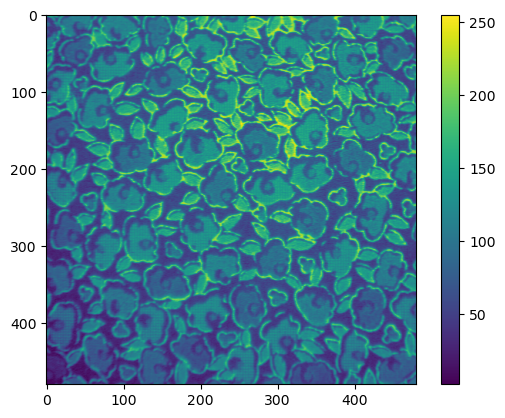

In [3]:
image_number = 10
# dimensionality (N) of subspace = 64
tile_w = 8
 
image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
image = image[:mindim, :mindim]

plt.imshow(image)
plt.colorbar()
plt.show();

In [4]:
def return_tiles(image, tile_width):
    """
    image: A 2D array
    tile_width: the width of a square tile
    """
    width, height = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_width
    num_tiles_y = height // tile_width

    # Initialize an empty array to store tiles
    # Reshape the image into tiles
    tiles = image[:num_tiles_y * tile_width, :num_tiles_x * tile_width].reshape(
        num_tiles_y, tile_width, num_tiles_x, tile_width)

    # Transpose the axes to get the desired shape
    tiles2d = tiles.transpose(0, 2, 1, 3).reshape(num_tiles_y, num_tiles_x, tile_width, tile_width)
    tiles1d = tiles2d.reshape(num_tiles_y*num_tiles_x, tile_width*tile_width)

    return tiles2d, tiles1d

In [5]:
# The data vector
im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
print(im_tiles2d.shape)
print(im_tiles1d.shape)

(60, 60, 8, 8)
(3600, 64)


In [6]:
def visualize_tiles(tiles_array):
    num_tiles_y, num_tiles_x, tile_width, _ = tiles_array.shape

    #subplot with a grid of tiles
    fig, axes = plt.subplots(num_tiles_y, num_tiles_x, figsize=(10, 10))

    # Iterate through each tile and display
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            axes[i, j].imshow(tiles_array[i, j, :, :], vmin=0, vmax=255)
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

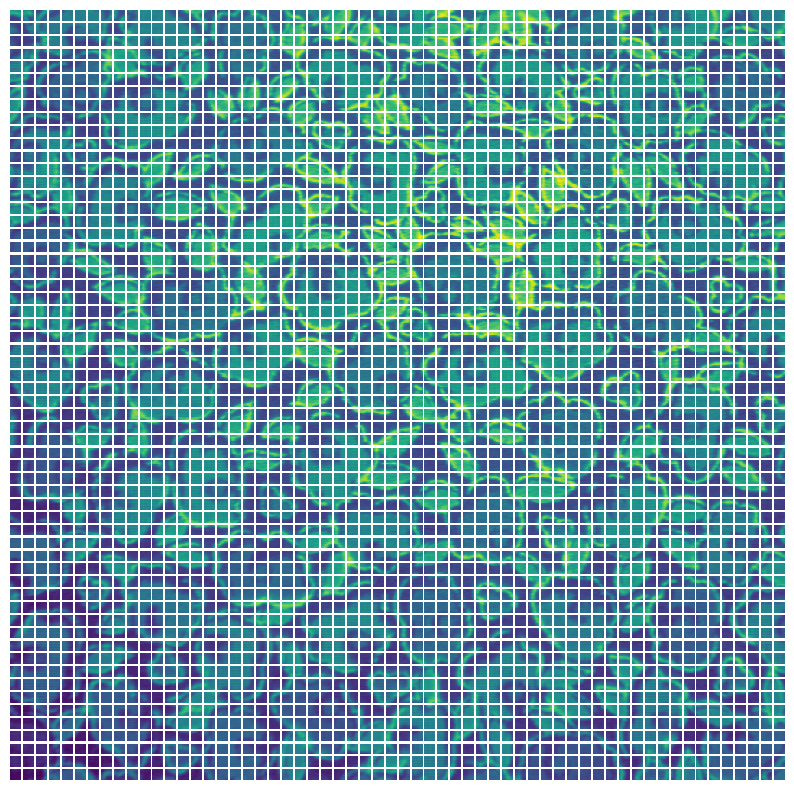

In [7]:
visualize_tiles(im_tiles2d)

In [8]:
im_tiles1d = im_tiles1d.astype(float)

### Decide the number of clusters
* And if needed, change the num_clusters argument in the start 

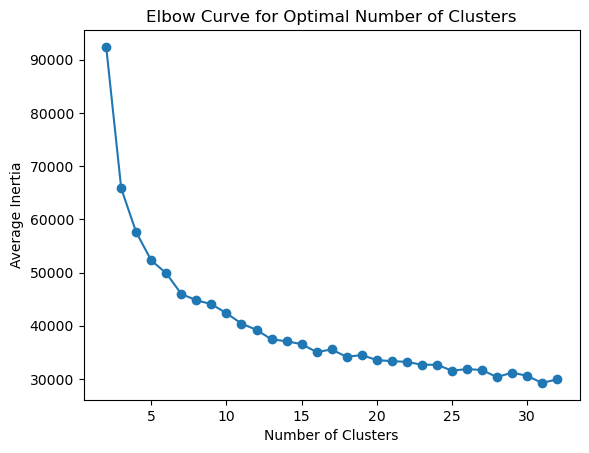

[92405.85879727956,
 65791.49707602269,
 57543.50933139105,
 52271.719566428415,
 49843.12776054791,
 45959.35536144656,
 44781.247837832925,
 44054.57694017407,
 42338.08063193192,
 40401.76214775064,
 39216.87610363342,
 37433.105969538075,
 37074.57291293261,
 36533.86221924309,
 35044.54657284347,
 35531.31695116236,
 34135.23577923207,
 34494.23526340118,
 33534.182041317144,
 33338.25137835032,
 33204.70716510432,
 32653.0028514301,
 32671.860204733475,
 31545.787161126915,
 31841.160028692342,
 31669.403467049287,
 30329.948299558295,
 31186.54763813349,
 30578.387210308665,
 29242.73008326142,
 29912.408343732684]

In [9]:
def calculate_inertia(data, centroids, cluster_indices):
    # Calculate within-cluster sum of squared distances
    # print(type(cluster_indices), cluster_indices.shape)
    distances = np.sum((data - centroids[cluster_indices]) ** 2)
    inertia = distances / len(data)
    return inertia

def elbow_method(data, max_clusters=32):
    inertias = []

    for num_clusters in range(2, max_clusters + 1):
        centroids, distortion = kmeans(data, num_clusters)
        cluster_indices, _ = vq(data, centroids)
        inertia = calculate_inertia(data, centroids, cluster_indices)
        inertias.append(inertia)

    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Inertia')
    plt.show()

    return inertias

elbow_method(im_tiles1d, 32)

Can perform clustering with kmeans, if the number of clusters are decided beforehand.

In [ ]:
# num_clusters = 20 
# def getKmeans(data, num_clusters):
#     # Adjust the number of clusters as needed
#     centroids, _ = kmeans(data, num_clusters)
#     print('data dimensions:', data.shape)
#     print('number of clusters:', num_clusters)
#     print('centroids shape:', centroids.shape)

#     #vector quatization
#     cluster_indices, _ = vq(data, centroids)
#     print('cluster_indices shape:', cluster_indices.shape)
#     return cluster_indices

# cluster_indices = getKmeans(im_tiles1d, num_clusters)

### Clustering more robustly, following the work of Candes,Sankoltanobi (2014)

To enforce the non-negativity constraint, we are trying the glmnet algorithm. To get it to work in python, we are using elastic net.

In [9]:
# def getRobustSSCV6(Y, sigma):
"""
Robust Subspace Clustering: Using GLMNet/ElasticNet
has beta_i = 0 constraint in a second way
https://glmnet.stanford.edu/articles/glmnet.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html
"""
# Step 1: Compute sparse coefficients
Y = im_tiles1d
N, n = Y.shape
#3600,64

B = np.zeros((N, N))
for i in range(N):
    
    y_i = Y[i, :]
    
    # Remove the i-th row from Y
    y_others = np.delete(Y, i, axis=0)
    A = y_others.T  # Transpose to match dimensions (n, N-1)
    b = y_i.T       # (n,)

    # Set alpha to control regularization, l1_ratio for L1 regularization
    alpha = 5.8   # Adjust this value as needed
    l1_ratio = 1  # 1.0 gives Lasso (L1) regularization only

    # Initialize the ElasticNet model with non-negativity constraint
    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True, fit_intercept=False, max_iter=5000)
    enet.fit(A, b)
    result = enet.coef_

    if i % 10 == 0:
        print('%.d th tile result:' % (i))
        print('L1 norm b', np.linalg.norm(b, 1))
        print('L1 norm x', np.linalg.norm(result, 1))
        print('sum of x', np.sum(result))
        print('L2 norm Ax-b', np.linalg.norm(A @ result - b, 2))
    
    # Insert zero at the i-th position to maintain original dimensions
    beta_i = np.insert(result, i, 0)
    B[i, :] = np.abs(beta_i)

print("checking rough beta range:", B[1])

# Step 2: Construct similarity graph
W = np.abs(B) + np.abs(B.T)

# Step 3: Compute degree matrix
D = np.diag(np.sum(W, axis=1))

# Step 4: Compute normalized Laplacian
D_sqrt_inv = np.linalg.inv(np.sqrt(D))
L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv

# Step 5: Compute the eigenvalues
eigenvalues, _ = np.linalg.eigh(L_norm)
sorted_eigenvalues = np.sort(eigenvalues)[::-1]
differences = np.diff(sorted_eigenvalues)
i_max = np.argmax(differences)
N = len(sorted_eigenvalues)
L_hat = N - (i_max + 1)

# To get the similarity matrix from the normalized Laplacian, we can use: S = I - L
S = np.eye(L_norm.shape[0]) - L_norm

# Step 6: Spectral clustering
spectral_clustering = SpectralClustering(n_clusters=L_hat, affinity='precomputed', random_state=0)
labels = spectral_clustering.fit_predict(W)
   
#     return labels

# robust_cluster_indices = getRobustSSCV6(im_tiles1d, sigma=50)
# print('robust_cluster_indices shape:', robust_cluster_indices.shape)

0 th tile result:
L1 norm b 6572.0
L1 norm x 0.9184168961089304
sum of x 0.9184168961089304
L2 norm Ax-b 39.996433411369836
10 th tile result:
L1 norm b 7509.0
L1 norm x 0.745072571090435
sum of x 0.745072571090435
L2 norm Ax-b 8.298860086817701
20 th tile result:
L1 norm b 4679.0
L1 norm x 0.6826388261552855
sum of x 0.6826388261552855
L2 norm Ax-b 13.073453162197254
30 th tile result:
L1 norm b 6268.0
L1 norm x 0.8563179332640511
sum of x 0.8563179332640511
L2 norm Ax-b 13.149448971988457
40 th tile result:
L1 norm b 11743.0
L1 norm x 1.3384122576150164
sum of x 1.3384122576150164
L2 norm Ax-b 12.680101781359589
50 th tile result:
L1 norm b 4760.0
L1 norm x 0.5782145654151118
sum of x 0.5782145654151118
L2 norm Ax-b 10.611445836558046
60 th tile result:
L1 norm b 4441.0
L1 norm x 0.7738565552205895
sum of x 0.7738565552205895
L2 norm Ax-b 33.05112986111259


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.578e+01, tolerance: 7.156e+01
  model = cd_fast.enet_coordinate_descent(


70 th tile result:
L1 norm b 7317.0
L1 norm x 0.6933843486952962
sum of x 0.6933843486952962
L2 norm Ax-b 7.076867845002221
80 th tile result:
L1 norm b 6329.0
L1 norm x 1.1454364510786479
sum of x 1.1454364510786479
L2 norm Ax-b 28.35386190170528
90 th tile result:
L1 norm b 7924.0
L1 norm x 1.028041027530654
sum of x 1.028041027530654
L2 norm Ax-b 15.264916595057448
100 th tile result:
L1 norm b 8374.0
L1 norm x 1.8456989016298802
sum of x 1.8456989016298802
L2 norm Ax-b 103.93434991553168
110 th tile result:
L1 norm b 7253.0
L1 norm x 1.313099703596217
sum of x 1.313099703596217
L2 norm Ax-b 56.238981458980945
120 th tile result:
L1 norm b 3409.0
L1 norm x 0.48293279255902455
sum of x 0.48293279255902455
L2 norm Ax-b 14.164516940877395
130 th tile result:
L1 norm b 5757.0
L1 norm x 0.6842871265034315
sum of x 0.6842871265034315
L2 norm Ax-b 8.461499184700394
140 th tile result:
L1 norm b 8616.0
L1 norm x 1.8729852394516104
sum of x 1.8729852394516104
L2 norm Ax-b 79.85748074009783
1

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e+02, tolerance: 1.466e+02
  model = cd_fast.enet_coordinate_descent(


250 th tile result:
L1 norm b 7022.0
L1 norm x 1.0688818327516665
sum of x 1.0688818327516665
L2 norm Ax-b 107.70467463433152
260 th tile result:
L1 norm b 4661.0
L1 norm x 0.780235420604483
sum of x 0.780235420604483
L2 norm Ax-b 15.827163228924231
270 th tile result:
L1 norm b 7933.0
L1 norm x 1.8422791086205215
sum of x 1.8422791086205215
L2 norm Ax-b 91.54218431522183
280 th tile result:
L1 norm b 8837.0
L1 norm x 0.968054501667956
sum of x 0.968054501667956
L2 norm Ax-b 12.277810054155344
290 th tile result:
L1 norm b 6369.0
L1 norm x 1.4563843953002584
sum of x 1.4563843953002584
L2 norm Ax-b 92.60604044660813
300 th tile result:
L1 norm b 7333.0
L1 norm x 1.5811411943949056
sum of x 1.5811411943949056
L2 norm Ax-b 64.43686048770131
310 th tile result:
L1 norm b 4766.0
L1 norm x 1.170099236008369
sum of x 1.170099236008369
L2 norm Ax-b 54.21464083173723
320 th tile result:
L1 norm b 7919.0
L1 norm x 1.5276627260008127
sum of x 1.5276627260008127
L2 norm Ax-b 86.26568255945803
330

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.681e+01, tolerance: 7.550e+01
  model = cd_fast.enet_coordinate_descent(


590 th tile result:
L1 norm b 6283.0
L1 norm x 0.9071442833079617
sum of x 0.9071442833079617
L2 norm Ax-b 21.99722712980007
600 th tile result:
L1 norm b 4507.0
L1 norm x 0.7308934551472462
sum of x 0.7308934551472462
L2 norm Ax-b 26.50329070052979
610 th tile result:
L1 norm b 7662.0
L1 norm x 1.2136803039908197
sum of x 1.2136803039908197
L2 norm Ax-b 43.069282556202175
620 th tile result:
L1 norm b 6224.0
L1 norm x 0.7494598970132869
sum of x 0.7494598970132869
L2 norm Ax-b 12.300127106369377
630 th tile result:
L1 norm b 8105.0
L1 norm x 1.2866820809011268
sum of x 1.2866820809011268
L2 norm Ax-b 110.84924382780768
640 th tile result:
L1 norm b 5749.0
L1 norm x 1.3712166911622274
sum of x 1.3712166911622274
L2 norm Ax-b 48.07614782002944
650 th tile result:
L1 norm b 5861.0
L1 norm x 0.9461280682997928
sum of x 0.9461280682997928
L2 norm Ax-b 93.74409466023512
660 th tile result:
L1 norm b 3841.0
L1 norm x 0.5487991409558423
sum of x 0.5487991409558423
L2 norm Ax-b 11.007916734969

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+02, tolerance: 1.085e+02
  model = cd_fast.enet_coordinate_descent(


780 th tile result:
L1 norm b 4721.0
L1 norm x 0.9070075232485603
sum of x 0.9070075232485603
L2 norm Ax-b 22.811543284130995


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.805e+01, tolerance: 7.352e+01
  model = cd_fast.enet_coordinate_descent(


790 th tile result:
L1 norm b 8573.0
L1 norm x 1.2171160342371479
sum of x 1.2171160342371479
L2 norm Ax-b 36.548269605973054
800 th tile result:
L1 norm b 6577.0
L1 norm x 1.379716724281907
sum of x 1.379716724281907
L2 norm Ax-b 86.1922951089513
810 th tile result:
L1 norm b 10054.0
L1 norm x 1.4522514778948183
sum of x 1.4522514778948183
L2 norm Ax-b 20.104602556280508
820 th tile result:
L1 norm b 5013.0
L1 norm x 1.1439455355752366
sum of x 1.1439455355752366
L2 norm Ax-b 43.36781527446161
830 th tile result:
L1 norm b 7320.0
L1 norm x 1.2233226444268772
sum of x 1.2233226444268772
L2 norm Ax-b 52.01665811698182
840 th tile result:
L1 norm b 6467.0
L1 norm x 1.1323835479722348
sum of x 1.1323835479722348
L2 norm Ax-b 109.46007603256353
850 th tile result:
L1 norm b 6464.0
L1 norm x 0.9716038741617768
sum of x 0.9716038741617768
L2 norm Ax-b 56.84071851129783
860 th tile result:
L1 norm b 5432.0
L1 norm x 1.3194745201700957
sum of x 1.3194745201700957
L2 norm Ax-b 27.18659526597079

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+02, tolerance: 1.203e+02
  model = cd_fast.enet_coordinate_descent(


1190 th tile result:
L1 norm b 8803.0
L1 norm x 2.5289678153217277
sum of x 2.5289678153217277
L2 norm Ax-b 131.86903202171283


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+02, tolerance: 9.659e+01
  model = cd_fast.enet_coordinate_descent(


1200 th tile result:
L1 norm b 4558.0
L1 norm x 0.9491892105655813
sum of x 0.9491892105655813
L2 norm Ax-b 50.86959618514268
1210 th tile result:
L1 norm b 6756.0
L1 norm x 1.609050365687197
sum of x 1.609050365687197
L2 norm Ax-b 76.91767655286117
1220 th tile result:
L1 norm b 4496.0
L1 norm x 0.6259327548223608
sum of x 0.6259327548223608
L2 norm Ax-b 14.606312455796878
1230 th tile result:
L1 norm b 11067.0
L1 norm x 1.7798830480998005
sum of x 1.7798830480998005
L2 norm Ax-b 54.09524939925268
1240 th tile result:
L1 norm b 7558.0
L1 norm x 1.561881964456802
sum of x 1.561881964456802
L2 norm Ax-b 65.53893102644517
1250 th tile result:
L1 norm b 7868.0
L1 norm x 1.3867091268934373
sum of x 1.3867091268934373
L2 norm Ax-b 177.40446052259225
1260 th tile result:
L1 norm b 3693.0
L1 norm x 0.6532127988350948
sum of x 0.6532127988350948
L2 norm Ax-b 35.11417151558222
1270 th tile result:
L1 norm b 7716.0
L1 norm x 1.368808614922123
sum of x 1.368808614922123
L2 norm Ax-b 53.1148328705

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e+02, tolerance: 1.633e+02
  model = cd_fast.enet_coordinate_descent(


1410 th tile result:
L1 norm b 10370.0
L1 norm x 1.7063191486434066
sum of x 1.7063191486434066
L2 norm Ax-b 102.35436909514303
1420 th tile result:
L1 norm b 7874.0
L1 norm x 1.3762619715446882
sum of x 1.3762619715446882
L2 norm Ax-b 68.8008614749197
1430 th tile result:
L1 norm b 6272.0
L1 norm x 0.7951626996198411
sum of x 0.7951626996198411
L2 norm Ax-b 32.30537418641915
1440 th tile result:
L1 norm b 5403.0
L1 norm x 0.865130423852406
sum of x 0.865130423852406
L2 norm Ax-b 103.48259830399675
1450 th tile result:
L1 norm b 10318.0
L1 norm x 1.3634487920856704
sum of x 1.3634487920856704
L2 norm Ax-b 30.636168370883
1460 th tile result:
L1 norm b 8277.0
L1 norm x 1.1157756672930539
sum of x 1.1157756672930539
L2 norm Ax-b 23.493853109233157
1470 th tile result:
L1 norm b 9444.0
L1 norm x 1.515764003449724
sum of x 1.515764003449724
L2 norm Ax-b 72.87423984807705
1480 th tile result:
L1 norm b 6308.0
L1 norm x 0.8602868559768244
sum of x 0.8602868559768244
L2 norm Ax-b 33.172302542

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e+01, tolerance: 2.017e+01
  model = cd_fast.enet_coordinate_descent(


1570 th tile result:
L1 norm b 4187.0
L1 norm x 0.923304846956537
sum of x 0.923304846956537
L2 norm Ax-b 38.531866991199735
1580 th tile result:
L1 norm b 8720.0
L1 norm x 1.0325183773240345
sum of x 1.0325183773240345
L2 norm Ax-b 16.742701779365024
1590 th tile result:
L1 norm b 8903.0
L1 norm x 1.126867045683788
sum of x 1.126867045683788
L2 norm Ax-b 70.55399118349742
1600 th tile result:
L1 norm b 9208.0
L1 norm x 1.0522776937460043
sum of x 1.0522776937460043
L2 norm Ax-b 17.306482088973453


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.395e+01, tolerance: 7.519e+01
  model = cd_fast.enet_coordinate_descent(


1610 th tile result:
L1 norm b 8342.0
L1 norm x 1.7076938557833146
sum of x 1.7076938557833146
L2 norm Ax-b 85.55792957202586
1620 th tile result:
L1 norm b 6781.0
L1 norm x 1.1458442395383963
sum of x 1.1458442395383963
L2 norm Ax-b 24.36840016508141
1630 th tile result:
L1 norm b 4757.0
L1 norm x 1.0588018383662277
sum of x 1.0588018383662277
L2 norm Ax-b 35.758187393031186


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.409e+02, tolerance: 1.160e+02
  model = cd_fast.enet_coordinate_descent(


1640 th tile result:
L1 norm b 8691.0
L1 norm x 1.0999405500322506
sum of x 1.0999405500322506
L2 norm Ax-b 14.929262142061745
1650 th tile result:
L1 norm b 8374.0
L1 norm x 1.1906227368997333
sum of x 1.1906227368997333
L2 norm Ax-b 37.16463161441849
1660 th tile result:
L1 norm b 9864.0
L1 norm x 1.5167479474963943
sum of x 1.5167479474963943
L2 norm Ax-b 48.596500908297976
1670 th tile result:
L1 norm b 9628.0
L1 norm x 1.662688365452337
sum of x 1.662688365452337
L2 norm Ax-b 71.718281888977
1680 th tile result:
L1 norm b 6136.0
L1 norm x 1.0149052357724542
sum of x 1.0149052357724542
L2 norm Ax-b 42.9624230675177


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.157e+01, tolerance: 7.274e+01
  model = cd_fast.enet_coordinate_descent(


1690 th tile result:
L1 norm b 6169.0
L1 norm x 0.8439398181711116
sum of x 0.8439398181711116
L2 norm Ax-b 18.155940427847266
1700 th tile result:
L1 norm b 7523.0
L1 norm x 1.2317259782372414
sum of x 1.2317259782372414
L2 norm Ax-b 41.552205636553545


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.778e+01, tolerance: 2.453e+01
  model = cd_fast.enet_coordinate_descent(


1710 th tile result:
L1 norm b 7338.0
L1 norm x 1.1155125474078107
sum of x 1.1155125474078107
L2 norm Ax-b 36.662054948487445
1720 th tile result:
L1 norm b 6134.0
L1 norm x 1.1890503858208439
sum of x 1.1890503858208439
L2 norm Ax-b 50.11101728323067
1730 th tile result:
L1 norm b 8373.0
L1 norm x 1.7372835551996224
sum of x 1.7372835551996224
L2 norm Ax-b 49.41553880149183
1740 th tile result:
L1 norm b 4971.0
L1 norm x 1.1416378968981493
sum of x 1.1416378968981493
L2 norm Ax-b 59.411444921451576
1750 th tile result:
L1 norm b 6727.0
L1 norm x 0.8212799115050089
sum of x 0.8212799115050089
L2 norm Ax-b 16.610796672810036


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.359e+01, tolerance: 7.108e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e+02, tolerance: 8.910e+01
  model = cd_fast.enet_coordinate_descent(


1760 th tile result:
L1 norm b 3927.0
L1 norm x 0.8264342547717627
sum of x 0.8264342547717627
L2 norm Ax-b 32.72911799717255


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.726e+01, tolerance: 7.089e+01
  model = cd_fast.enet_coordinate_descent(


1770 th tile result:
L1 norm b 4949.0
L1 norm x 0.7789533826022472
sum of x 0.7789533826022472
L2 norm Ax-b 32.7544621047126
1780 th tile result:
L1 norm b 5944.0
L1 norm x 1.1348248487847483
sum of x 1.1348248487847483
L2 norm Ax-b 33.365667263059734
1790 th tile result:
L1 norm b 6871.0
L1 norm x 1.7635465952380316
sum of x 1.7635465952380316
L2 norm Ax-b 41.85908108998929
1800 th tile result:
L1 norm b 3088.0
L1 norm x 0.7138747378057703
sum of x 0.7138747378057703
L2 norm Ax-b 33.2779495426463
1810 th tile result:
L1 norm b 7420.0
L1 norm x 0.8988012664880589
sum of x 0.8988012664880589
L2 norm Ax-b 9.510428905592107
1820 th tile result:
L1 norm b 3750.0
L1 norm x 0.49357081215029874
sum of x 0.49357081215029874
L2 norm Ax-b 11.917126349691046
1830 th tile result:
L1 norm b 8474.0
L1 norm x 1.4991919028580922
sum of x 1.4991919028580922
L2 norm Ax-b 118.17072102863416
1840 th tile result:
L1 norm b 7337.0
L1 norm x 1.1696330726870072
sum of x 1.1696330726870072
L2 norm Ax-b 95.6572

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e+02, tolerance: 1.285e+02
  model = cd_fast.enet_coordinate_descent(


1990 th tile result:
L1 norm b 8819.0
L1 norm x 1.2226092590687876
sum of x 1.2226092590687876
L2 norm Ax-b 21.2695694903821
2000 th tile result:
L1 norm b 7281.0
L1 norm x 1.1265344948593443
sum of x 1.1265344948593443
L2 norm Ax-b 55.52836839361626
2010 th tile result:
L1 norm b 9700.0
L1 norm x 1.4194065264050062
sum of x 1.4194065264050062
L2 norm Ax-b 34.89698801078188
2020 th tile result:
L1 norm b 4880.0
L1 norm x 0.7106630907086811
sum of x 0.7106630907086811
L2 norm Ax-b 14.997856459010606


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.372e+01, tolerance: 6.878e+01
  model = cd_fast.enet_coordinate_descent(


2030 th tile result:
L1 norm b 5709.0
L1 norm x 1.2104912302974022
sum of x 1.2104912302974022
L2 norm Ax-b 64.35048982692277
2040 th tile result:
L1 norm b 2762.0
L1 norm x 0.5930294184278739
sum of x 0.5930294184278739
L2 norm Ax-b 21.625960304045634
2050 th tile result:
L1 norm b 8100.0
L1 norm x 1.5126044328760169
sum of x 1.5126044328760169
L2 norm Ax-b 72.86671731099513
2060 th tile result:
L1 norm b 7411.0
L1 norm x 1.2011618627667646
sum of x 1.2011618627667646
L2 norm Ax-b 77.06478977002044
2070 th tile result:
L1 norm b 6337.0
L1 norm x 1.0259963964835226
sum of x 1.0259963964835226
L2 norm Ax-b 29.976433081449283
2080 th tile result:
L1 norm b 7466.0
L1 norm x 1.2643944700880363
sum of x 1.2643944700880363
L2 norm Ax-b 54.22344925454805
2090 th tile result:
L1 norm b 5856.0
L1 norm x 1.4266424527279828
sum of x 1.4266424527279828
L2 norm Ax-b 85.62169134988265
2100 th tile result:
L1 norm b 2646.0
L1 norm x 0.5744690877409399
sum of x 0.5744690877409399
L2 norm Ax-b 31.71058

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.391e+01, tolerance: 7.942e+01
  model = cd_fast.enet_coordinate_descent(


2160 th tile result:
L1 norm b 3137.0
L1 norm x 0.8254616701083489
sum of x 0.8254616701083489
L2 norm Ax-b 29.34015710665459


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.793e+01, tolerance: 2.567e+01
  model = cd_fast.enet_coordinate_descent(


2170 th tile result:
L1 norm b 7143.0
L1 norm x 1.0914655138965625
sum of x 1.0914655138965625
L2 norm Ax-b 20.36419632097314
2180 th tile result:
L1 norm b 3820.0
L1 norm x 0.6075109584854574
sum of x 0.6075109584854574
L2 norm Ax-b 19.458286839002437
2190 th tile result:
L1 norm b 9430.0
L1 norm x 1.3468080445520814
sum of x 1.3468080445520814
L2 norm Ax-b 40.55064791030846
2200 th tile result:
L1 norm b 10074.0
L1 norm x 1.6802832487413384
sum of x 1.6802832487413384
L2 norm Ax-b 71.34197119335799
2210 th tile result:
L1 norm b 6789.0
L1 norm x 1.097497344048953
sum of x 1.097497344048953
L2 norm Ax-b 73.26704570982665
2220 th tile result:
L1 norm b 2673.0
L1 norm x 0.6546841200455662
sum of x 0.6546841200455662
L2 norm Ax-b 28.235487385075096
2230 th tile result:
L1 norm b 7573.0
L1 norm x 1.0077342059344576
sum of x 1.0077342059344576
L2 norm Ax-b 12.74667203878327


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.220e+01, tolerance: 4.901e+01
  model = cd_fast.enet_coordinate_descent(


2240 th tile result:
L1 norm b 6802.0
L1 norm x 0.8900765848911878
sum of x 0.8900765848911878
L2 norm Ax-b 57.89937304378656
2250 th tile result:
L1 norm b 5361.0
L1 norm x 1.625047464900693
sum of x 1.625047464900693
L2 norm Ax-b 50.884177706753235
2260 th tile result:
L1 norm b 9945.0
L1 norm x 1.103547455480602
sum of x 1.103547455480602
L2 norm Ax-b 10.962670654492877
2270 th tile result:
L1 norm b 8609.0
L1 norm x 1.2684400363456245
sum of x 1.2684400363456245
L2 norm Ax-b 89.44049772829133
2280 th tile result:
L1 norm b 1728.0
L1 norm x 0.25116056428581374
sum of x 0.25116056428581374
L2 norm Ax-b 13.47305894419008
2290 th tile result:
L1 norm b 7753.0
L1 norm x 1.03160621356216
sum of x 1.03160621356216
L2 norm Ax-b 11.294895168354635
2300 th tile result:
L1 norm b 6105.0
L1 norm x 0.9961310596749007
sum of x 0.9961310596749007
L2 norm Ax-b 20.8315500026658
2310 th tile result:
L1 norm b 5512.0
L1 norm x 1.2505122615961244
sum of x 1.2505122615961244
L2 norm Ax-b 55.67201725070

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+02, tolerance: 1.328e+02
  model = cd_fast.enet_coordinate_descent(


2700 th tile result:
L1 norm b 5497.0
L1 norm x 0.9055069491264482
sum of x 0.9055069491264482
L2 norm Ax-b 59.05238260080531


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e+01, tolerance: 4.375e+01
  model = cd_fast.enet_coordinate_descent(


2710 th tile result:
L1 norm b 6333.0
L1 norm x 0.7097560341470497
sum of x 0.7097560341470497
L2 norm Ax-b 10.869970058293891
2720 th tile result:
L1 norm b 6673.0
L1 norm x 0.9181425023145675
sum of x 0.9181425023145675
L2 norm Ax-b 11.418217811812806
2730 th tile result:
L1 norm b 4271.0
L1 norm x 0.8126564527037945
sum of x 0.8126564527037945
L2 norm Ax-b 33.35848969276872
2740 th tile result:
L1 norm b 7461.0
L1 norm x 1.1849979073417205
sum of x 1.1849979073417205
L2 norm Ax-b 78.39777995830575
2750 th tile result:
L1 norm b 6060.0
L1 norm x 1.0329442391242645
sum of x 1.0329442391242645
L2 norm Ax-b 78.70412373247565
2760 th tile result:
L1 norm b 5744.0
L1 norm x 0.819555857041911
sum of x 0.819555857041911
L2 norm Ax-b 40.51074467148072
2770 th tile result:
L1 norm b 5486.0
L1 norm x 0.6183901770106409
sum of x 0.6183901770106409
L2 norm Ax-b 13.511375519041769
2780 th tile result:
L1 norm b 9655.0
L1 norm x 1.4254799690116147
sum of x 1.4254799690116147
L2 norm Ax-b 32.412423

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.663e+01, tolerance: 6.115e+01
  model = cd_fast.enet_coordinate_descent(


2910 th tile result:
L1 norm b 6179.0
L1 norm x 1.1537163857989894
sum of x 1.1537163857989894
L2 norm Ax-b 96.26845523430777
2920 th tile result:
L1 norm b 3051.0
L1 norm x 0.6585000017994485
sum of x 0.6585000017994485
L2 norm Ax-b 30.082956517691567
2930 th tile result:
L1 norm b 3819.0
L1 norm x 0.7048313472727739
sum of x 0.7048313472727739
L2 norm Ax-b 20.637803849780838
2940 th tile result:
L1 norm b 3240.0
L1 norm x 0.5493356130578088
sum of x 0.5493356130578088
L2 norm Ax-b 45.232348930372275
2950 th tile result:
L1 norm b 2350.0
L1 norm x 0.7370890115265467
sum of x 0.7370890115265467
L2 norm Ax-b 22.023540263230732
2960 th tile result:
L1 norm b 6518.0
L1 norm x 1.2188923435234371
sum of x 1.2188923435234371
L2 norm Ax-b 40.998674172828984
2970 th tile result:
L1 norm b 6577.0
L1 norm x 0.9638202198394256
sum of x 0.9638202198394256
L2 norm Ax-b 75.87485219182994
2980 th tile result:
L1 norm b 5464.0
L1 norm x 1.0496427154777102
sum of x 1.0496427154777102
L2 norm Ax-b 36.21

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e+01, tolerance: 2.342e+01
  model = cd_fast.enet_coordinate_descent(


3220 th tile result:
L1 norm b 5061.0
L1 norm x 1.0012584137063205
sum of x 1.0012584137063205
L2 norm Ax-b 42.63069083874955
3230 th tile result:
L1 norm b 6881.0
L1 norm x 0.9607305323393016
sum of x 0.9607305323393016
L2 norm Ax-b 12.645145719477359
3240 th tile result:
L1 norm b 2083.0
L1 norm x 0.37453295177551665
sum of x 0.37453295177551665
L2 norm Ax-b 62.84905768385277
3250 th tile result:
L1 norm b 2170.0
L1 norm x 0.4670677604863639
sum of x 0.4670677604863639
L2 norm Ax-b 25.057816221407784
3260 th tile result:
L1 norm b 5068.0
L1 norm x 0.9486169745156481
sum of x 0.9486169745156481
L2 norm Ax-b 43.48584419915609
3270 th tile result:
L1 norm b 7701.0
L1 norm x 1.1936926880800542
sum of x 1.1936926880800542
L2 norm Ax-b 24.980043380803227
3280 th tile result:
L1 norm b 6605.0
L1 norm x 1.0526930282585725
sum of x 1.0526930282585725
L2 norm Ax-b 74.79756490844272
3290 th tile result:
L1 norm b 5536.0
L1 norm x 0.836813507712712
sum of x 0.836813507712712
L2 norm Ax-b 18.8518

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.767e+01, tolerance: 4.636e+01
  model = cd_fast.enet_coordinate_descent(


3330 th tile result:
L1 norm b 5638.0
L1 norm x 1.0739912618184677
sum of x 1.0739912618184677
L2 norm Ax-b 29.542894762338427
3340 th tile result:
L1 norm b 4591.0
L1 norm x 0.9087818813913464
sum of x 0.9087818813913464
L2 norm Ax-b 44.33514888204943


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.630e+01, tolerance: 7.552e+01
  model = cd_fast.enet_coordinate_descent(


3350 th tile result:
L1 norm b 4289.0
L1 norm x 0.5685997328447842
sum of x 0.5685997328447842
L2 norm Ax-b 14.644117075653744
3360 th tile result:
L1 norm b 1932.0
L1 norm x 0.2096654230656892
sum of x 0.2096654230656892
L2 norm Ax-b 11.314983840896085
3370 th tile result:
L1 norm b 3632.0
L1 norm x 0.6104466785105773
sum of x 0.6104466785105773
L2 norm Ax-b 30.468699935874646
3380 th tile result:
L1 norm b 2501.0
L1 norm x 0.37382278998933005
sum of x 0.37382278998933005
L2 norm Ax-b 14.294988113221436
3390 th tile result:
L1 norm b 2853.0
L1 norm x 0.4041349340728055
sum of x 0.4041349340728055
L2 norm Ax-b 15.395548578774973
3400 th tile result:
L1 norm b 4173.0
L1 norm x 0.7412820316539808
sum of x 0.7412820316539808
L2 norm Ax-b 26.278403135253747
3410 th tile result:
L1 norm b 6593.0
L1 norm x 1.0536182743693012
sum of x 1.0536182743693012
L2 norm Ax-b 20.96476567845751
3420 th tile result:
L1 norm b 1478.0
L1 norm x 0.19990042658867926
sum of x 0.19990042658867926
L2 norm Ax-b 

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.073e+01, tolerance: 3.892e+01
  model = cd_fast.enet_coordinate_descent(


3500 th tile result:
L1 norm b 4797.0
L1 norm x 1.2455062773094778
sum of x 1.2455062773094778
L2 norm Ax-b 74.31312058546283
3510 th tile result:
L1 norm b 8221.0
L1 norm x 1.1799551283513738
sum of x 1.1799551283513738
L2 norm Ax-b 22.215577897814416
3520 th tile result:
L1 norm b 4041.0
L1 norm x 0.4536436661000697
sum of x 0.4536436661000697
L2 norm Ax-b 9.82346783275276
3530 th tile result:
L1 norm b 5641.0
L1 norm x 0.9331476243232542
sum of x 0.9331476243232542
L2 norm Ax-b 72.23786154059616
3540 th tile result:
L1 norm b 674.0
L1 norm x 0.17670127486315057
sum of x 0.17670127486315057
L2 norm Ax-b 20.641829048015715
3550 th tile result:
L1 norm b 1435.0
L1 norm x 0.5622187572290257
sum of x 0.5622187572290257
L2 norm Ax-b 30.101125735898066
3560 th tile result:
L1 norm b 2426.0
L1 norm x 0.6260814748130014
sum of x 0.6260814748130014
L2 norm Ax-b 29.186961493450664
3570 th tile result:
L1 norm b 4531.0
L1 norm x 1.4575074180093701
sum of x 1.4575074180093701
L2 norm Ax-b 52.792

In [10]:
print(L_hat)
print(labels.shape)

1810
(3600,)


In [11]:
# the shape of W is a square matrix (num_patches, num_patches) = (1024,1024)
# W.shape
im_tiles1d.shape

(3600, 64)

Debugging the simillarity matrix

determinant of W similarity matrix: 0.0


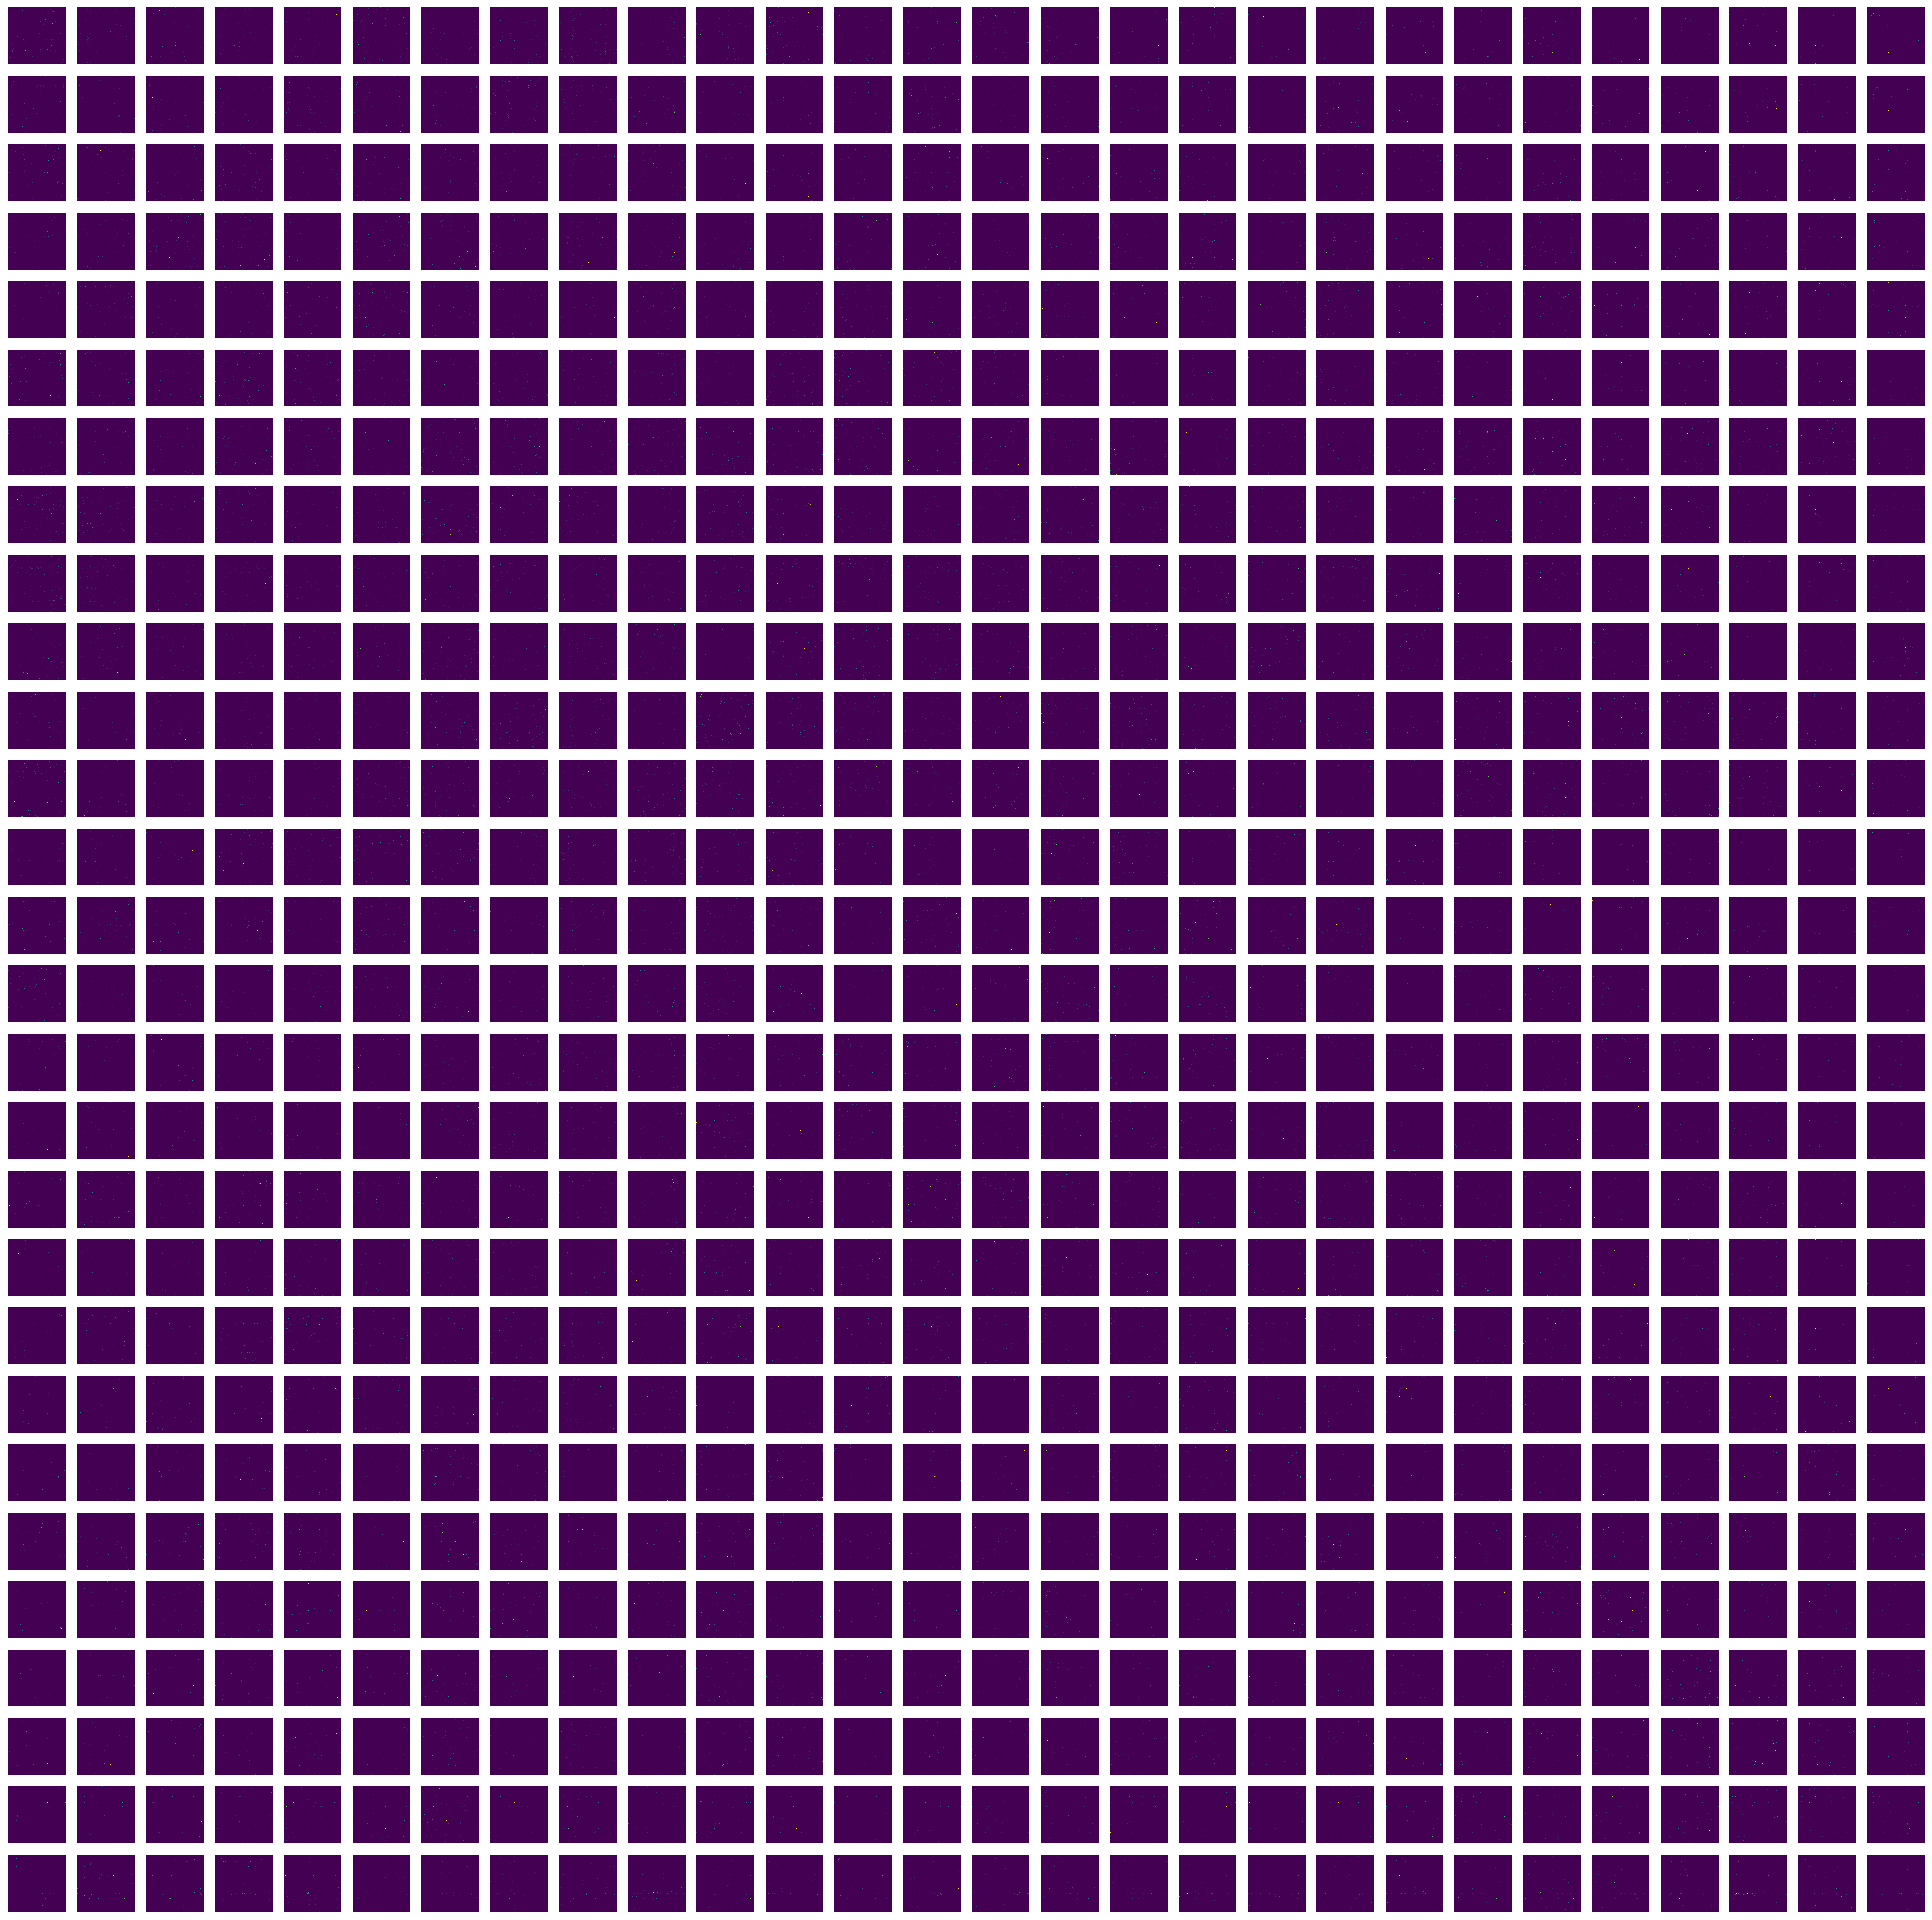

In [12]:
print('determinant of W similarity matrix:', np.linalg.det(W))
block_size = 128
block_cnt = int(im_tiles1d.shape[0]/block_size)
#8

#subplot with a grid of tiles
fig, axes = plt.subplots(block_cnt, block_cnt, figsize=(30, 30))

# Iterate through each tile and display
for i in range(block_cnt):
    for j in range(block_cnt):
        W_matrix = W[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        normalized_W_matrix = (W_matrix - np.min(W_matrix)) / (np.max(W_matrix) - np.min(W_matrix))
        axes[i, j].imshow(normalized_W_matrix, cmap='viridis', interpolation='none')
        axes[i, j].axis('off')  # Turn off axis labels

plt.show()

determinant of W similarity matrix: 0.0


Text(0, 0.5, 'Frequency')

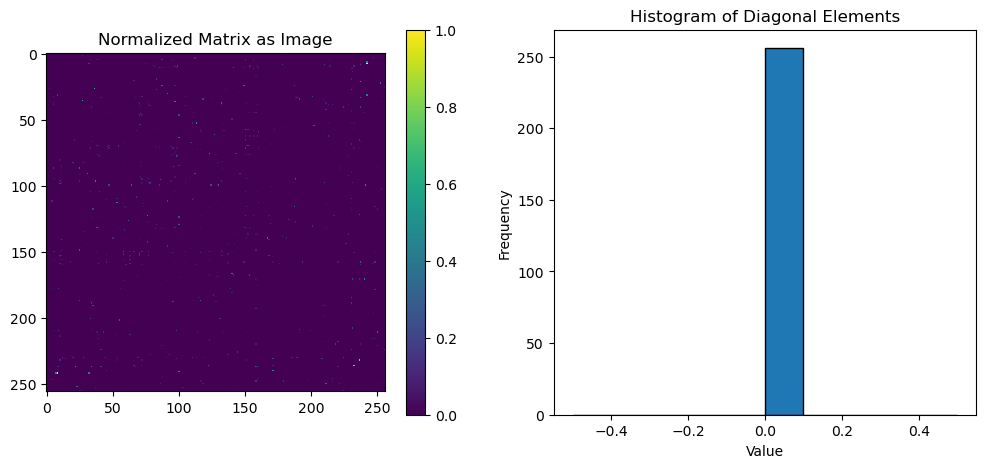

In [13]:
print('determinant of W similarity matrix:', np.linalg.det(W))
block_size = 256
W_matrix = W[:block_size,:block_size]

# print(W_matrix)

# Normalize the W_matrix to the range [0, 1]
normalized_W_matrix = (W_matrix - np.min(W_matrix)) / (np.max(W_matrix) - np.min(W_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the W_matrix
diagonal_elements = np.diag(W_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_W_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

Edit the above single-block image to see if the choice of the "slice" of W has different patterns.
This confirms that the high similarity is NOT periodic on the patch number.
Now we need to find the row numbers that give these numbers.

top 5 similarities are in these indices in order [1437  441  667  984 1934]


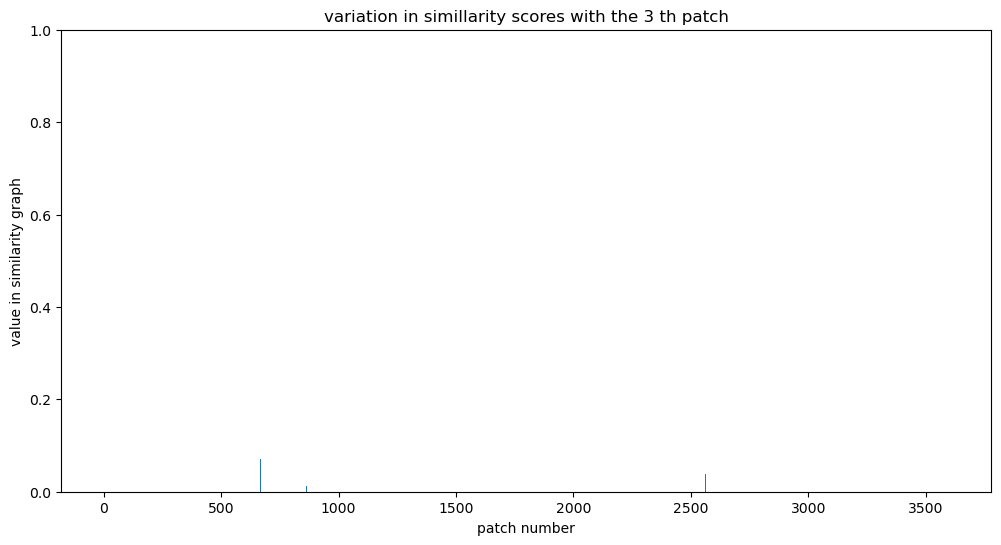

In [14]:
plt.figure(figsize=(12, 6))
path_num_ex = 3
data = W[path_num_ex,:]

#sorted values
top_count = 5
top_indices = np.argpartition(data, -top_count)[-top_count:]
top_indices = top_indices[np.argsort(data[top_indices])][::-1]
print("top %d similarities are in these indices in order"%(top_count) ,top_indices)


plt.bar(range(len(data)), data)
plt.xlabel('patch number')
plt.ylabel('value in similarity graph')
plt.ylim(0, 1)
plt.title('variation in simillarity scores with the %d th patch'%(path_num_ex))
plt.show()

top 7 similarities are in these indices in order [3483 3445  242 2602  463]


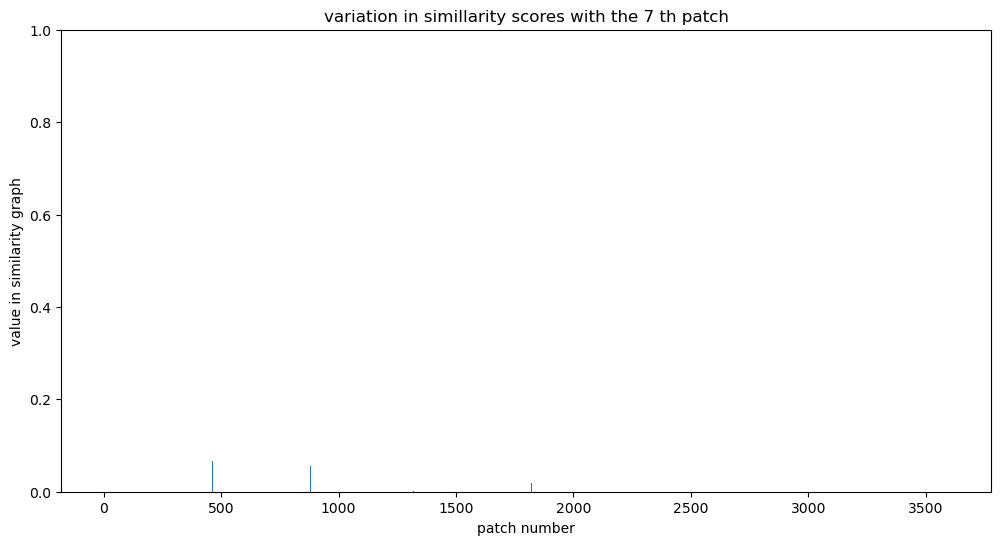

In [15]:
plt.figure(figsize=(12, 6))
path_num_ex = 7
data = W[path_num_ex,:]

#sorted values
top_count = 5
top_indices = np.argpartition(data, -top_count)[-top_count:]
top_indices = top_indices[np.argsort(data[top_indices])][::-1]
print("top %d similarities are in these indices in order"%(path_num_ex) ,top_indices)


plt.bar(range(len(data)), data)
plt.xlabel('patch number')
plt.ylabel('value in similarity graph')
plt.ylim(0, 1)
plt.title('variation in simillarity scores with the %d th patch'%(path_num_ex))
plt.show()

Looks like there are 3 clear patches that are common all throughout.
Can we visualise these 3 patches?

Be careful with the colorbar scale (vmin, vmax)

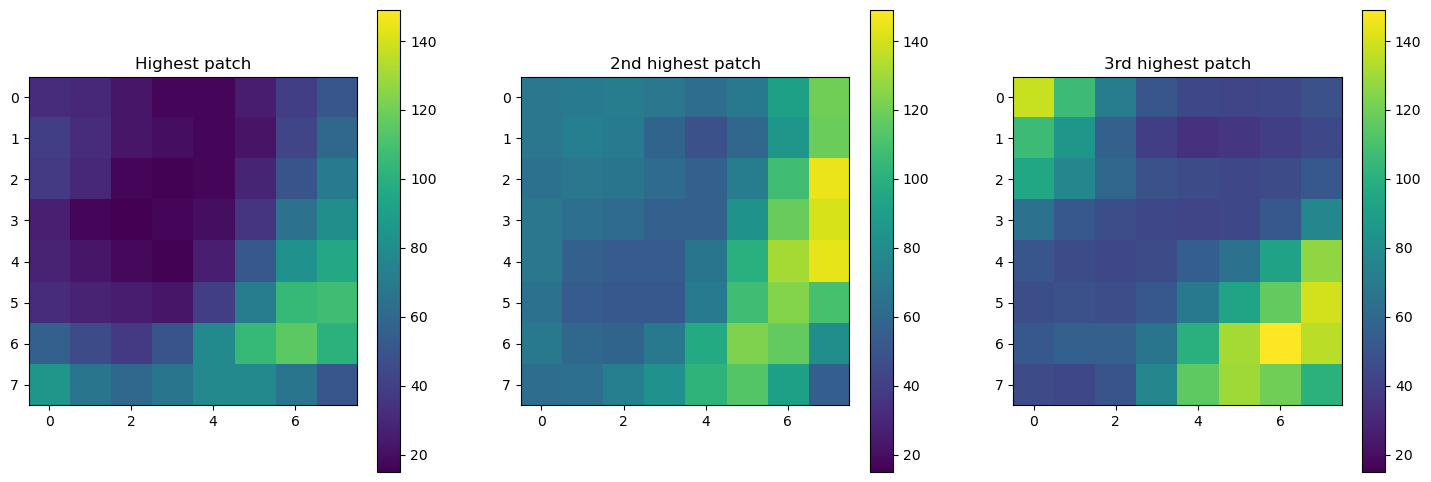

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
data1 = im_tiles1d[top_indices[0]]
data2 = im_tiles1d[top_indices[1]]
# data2 = im_tiles1d[15]
data3 = im_tiles1d[top_indices[2]]

# option 1
vmin = min(data1.min(), data2.min(), data3.min())
vmax = max(data1.max(), data2.max(), data3.max())

# option 2
# vmin = 0
# vmax = 255

img1 = axes[0].imshow(data1.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title('Highest patch')

img2 = axes[1].imshow(data2.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title('2nd highest patch')

img3 = axes[2].imshow(data3.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axes[2].set_title('3rd highest patch')

fig.colorbar(img1, ax=axes[0], orientation='vertical')
fig.colorbar(img2, ax=axes[1], orientation='vertical')
fig.colorbar(img3, ax=axes[2], orientation='vertical')

To check if the behaviour is simillar with other patches as well: 
Is a random patch also having the same "visual detail" as the patches having high similarity?: 
Change the selection of the data and see. (Ive changed the index for data2)

Checking the index number of "interesting" patches- edges and black regions, and look at the numerical similarity.

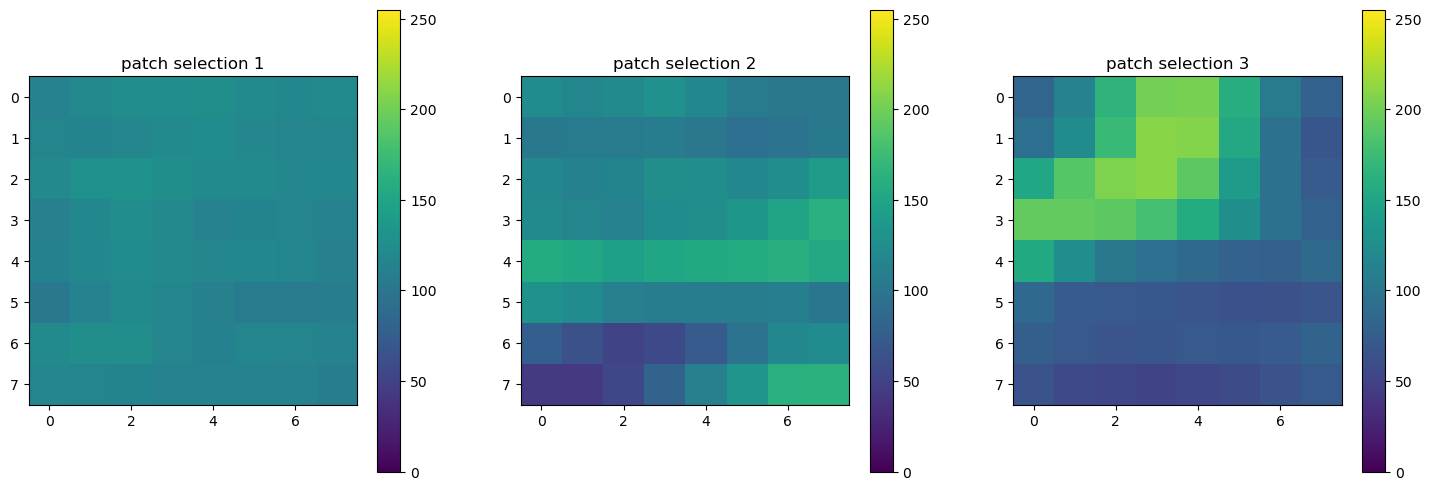

In [17]:
nice_indices = [10,300,330]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
data1 = im_tiles1d[nice_indices[0]]
data2 = im_tiles1d[nice_indices[1]]
data3 = im_tiles1d[nice_indices[2]]

# option 1
# vmin = min(data1.min(), data2.min(), data3.min())
# vmax = max(data1.max(), data2.max(), data3.max())

# option 2
vmin = 0
vmax = 255

img1 = axes[0].imshow(data1.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title('patch selection 1')

img2 = axes[1].imshow(data2.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title('patch selection 2')

img3 = axes[2].imshow(data3.reshape(8,8), cmap='viridis', vmin=vmin, vmax=vmax)
axes[2].set_title('patch selection 3')

fig.colorbar(img1, ax=axes[0], orientation='vertical')
fig.colorbar(img2, ax=axes[1], orientation='vertical')
fig.colorbar(img3, ax=axes[2], orientation='vertical')

top 10 similarities are in these indices in order [  99 1536  153  232  889]


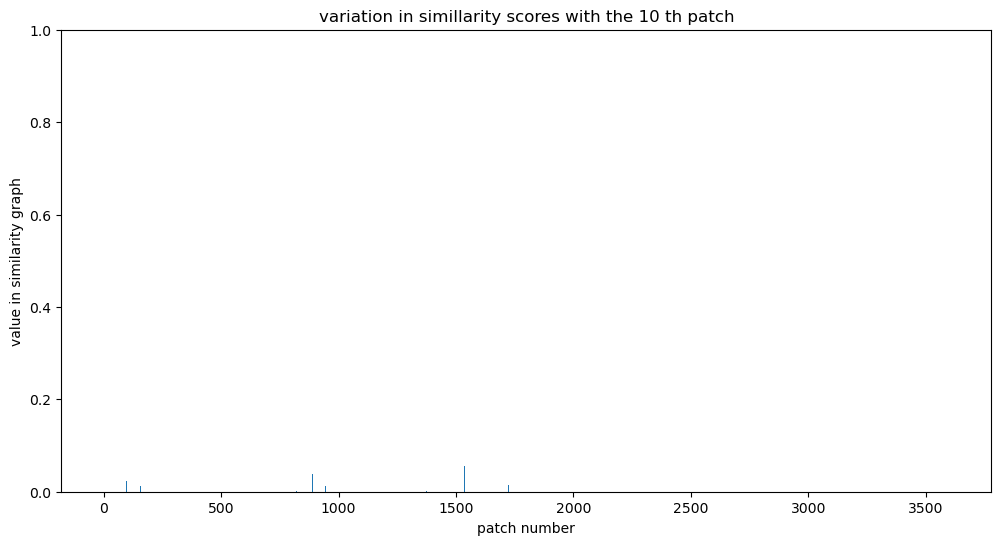

In [18]:
plt.figure(figsize=(12, 6))
path_num_ex = 10
data = W[path_num_ex,:]

#sorted values
top_count = 5
top_indices = np.argpartition(data, -top_count)[-top_count:]
top_indices = top_indices[np.argsort(data[top_indices])][::-1]
print("top %d similarities are in these indices in order"%(path_num_ex) ,top_indices)


plt.bar(range(len(data)), data)
plt.xlabel('patch number')
plt.ylabel('value in similarity graph')
plt.ylim(0, 1)
plt.title('variation in simillarity scores with the %d th patch'%(path_num_ex))
plt.show()

top 300 similarities are in these indices in order [3243 1207 3541 2705 1410]


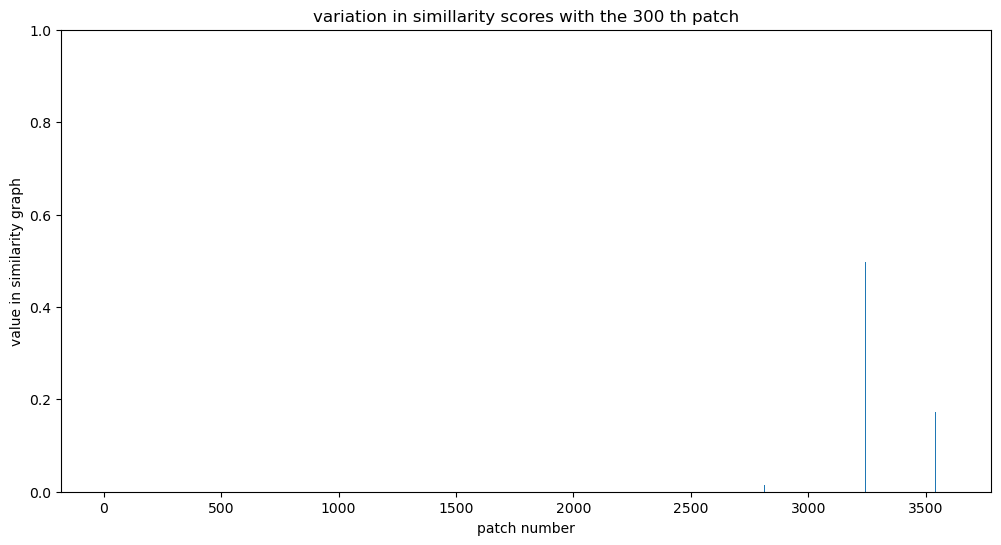

In [19]:
plt.figure(figsize=(12, 6))
path_num_ex = 300
data = W[path_num_ex,:]

#sorted values
top_count = 5
top_indices = np.argpartition(data, -top_count)[-top_count:]
top_indices = top_indices[np.argsort(data[top_indices])][::-1]
print("top %d similarities are in these indices in order"%(path_num_ex) ,top_indices)


plt.bar(range(len(data)), data)
plt.xlabel('patch number')
plt.ylabel('value in similarity graph')
plt.ylim(0, 1)
plt.title('variation in simillarity scores with the %d th patch'%(path_num_ex))
plt.show()

top 330 similarities are in these indices in order [2953 2148 2263 2025 1374]


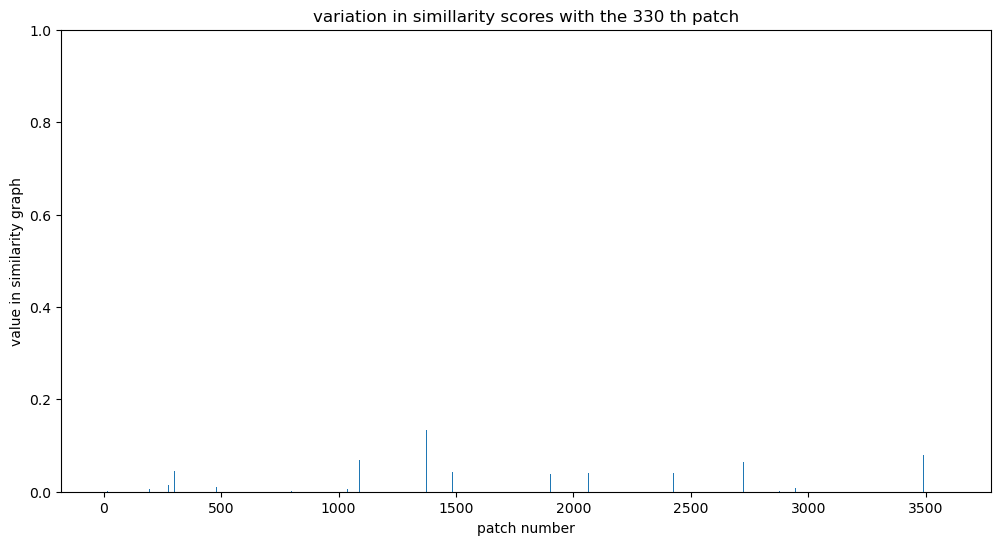

In [20]:
plt.figure(figsize=(12, 6))
path_num_ex = 330
data = W[path_num_ex,:]

#sorted values
top_count = 5
top_indices = np.argpartition(data, -top_count)[-top_count:]
top_indices = top_indices[np.argsort(data[top_indices])][::-1]
print("top %d similarities are in these indices in order"%(path_num_ex) ,top_indices)


plt.bar(range(len(data)), data)
plt.xlabel('patch number')
plt.ylabel('value in similarity graph')
plt.ylim(0, 1)
plt.title('variation in simillarity scores with the %d th patch'%(path_num_ex))
plt.show()

Debugging the D matrix: There must be a 'zero' in the diagonal of the D matrix.

determinant of D sqrt inv: inf


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Text(0, 0.5, 'Frequency')

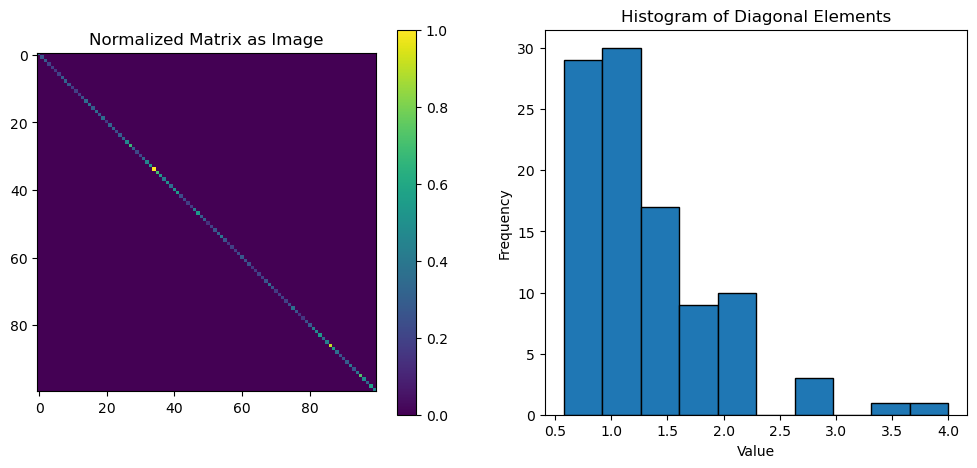

In [21]:
print('determinant of D sqrt inv:', np.linalg.det(D))
block = 100
matrix = D[:block,:block]
# print(matrix)

# Normalize the matrix to the range [0, 1]
normalized_matrix = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the matrix
diagonal_elements = np.diag(matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')


determinant of D_sqrt_inv: 0.0


Text(0, 0.5, 'Frequency')

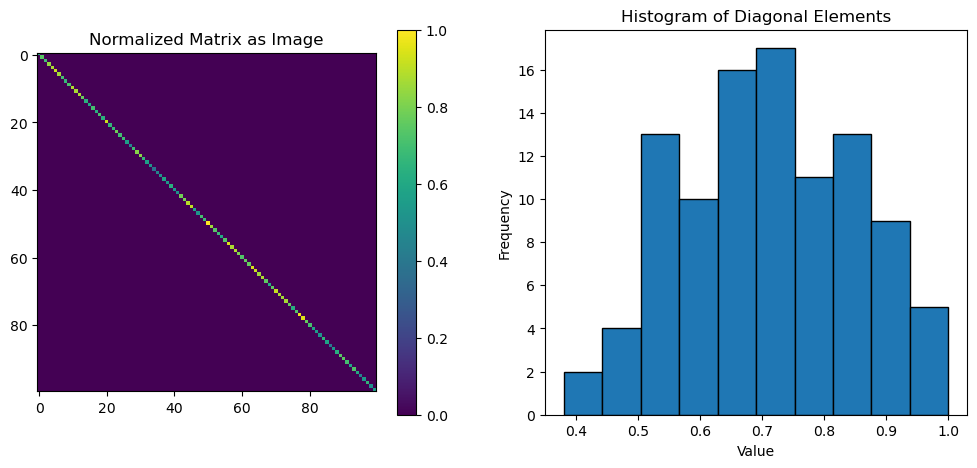

In [22]:
print('determinant of D_sqrt_inv:', np.linalg.det(D_sqrt_inv))
root_inv_matrix = D_sqrt_inv[:block,:block]
# print(root_inv_matrix)

# Normalize the root_inv_matrix to the range [0, 1]
normalized_root_inv_matrix = (root_inv_matrix - np.min(root_inv_matrix)) / (np.max(root_inv_matrix) - np.min(root_inv_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the root_inv_matrix
diagonal_elements = np.diag(normalized_root_inv_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_root_inv_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')


determinant of L_norm: 2.6520040657518204e-59


Text(0, 0.5, 'Frequency')

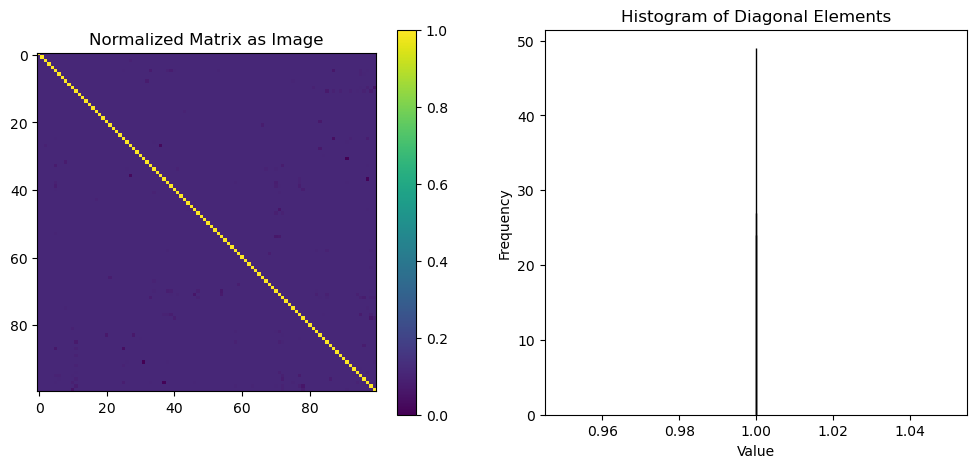

In [23]:
print('determinant of L_norm:', np.linalg.det(L_norm))
L_norm_matrix = L_norm[:block,:block]
# print(L_norm_matrix)

# Normalize the L_norm_matrix to the range [0, 1]
normalized_L_norm_matrix = (L_norm_matrix - np.min(L_norm_matrix)) / (np.max(L_norm_matrix) - np.min(L_norm_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the L_norm_matrix
diagonal_elements = np.diag(normalized_L_norm_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_L_norm_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

determinant of S: 0.0


Text(0, 0.5, 'Frequency')

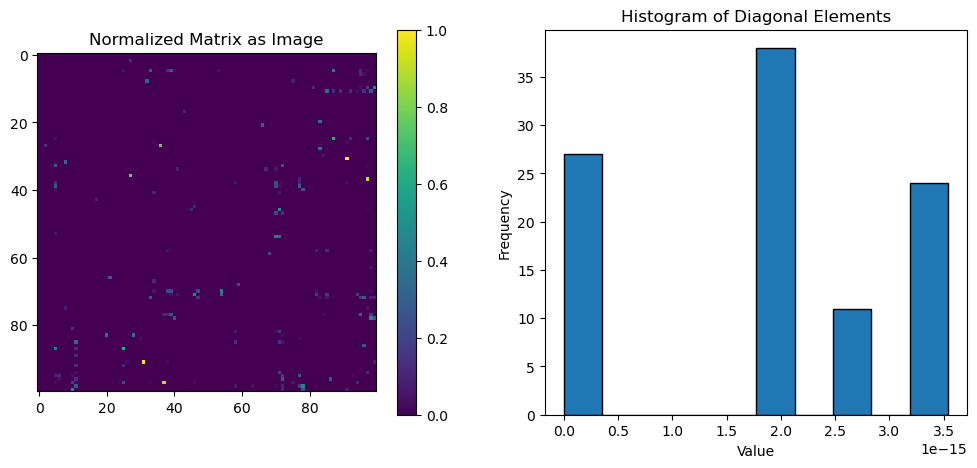

In [24]:
# To get the similarity matrix from the normalized Laplacian, we can use: S = I - L
S = np.eye(L_norm.shape[0]) - L_norm

print('determinant of S:', np.linalg.det(S))
S_matrix = S[:block,:block]
# print(S_matrix)

# Normalize the S_matrix to the range [0, 1]
normalized_S_matrix = (S_matrix - np.min(S_matrix)) / (np.max(S_matrix) - np.min(S_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the S_matrix
diagonal_elements = np.diag(normalized_S_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_S_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

Using a library to get the normalized Laplacian

In [ ]:
from scipy.sparse.csgraph import laplacian
L_norm_v2 = laplacian(W, normed=True)

# print(L_norm_v2)
print(L_norm_v2.shape)
print(np.max(L_norm_v2))
print(np.min(L_norm_v2))

print(np.sum(L_norm_v2 - np.eye(N)))
print(np.max(L_norm_v2 - np.eye(N)))
print(np.min(L_norm_v2 - np.eye(N)))

eigenvalues, _ = np.linalg.eigh(L_norm_v2)
# print(eigenvalues)

sorted_eigenvalues = np.sort(eigenvalues)[::-1]
print(sorted_eigenvalues)

differences = np.diff(sorted_eigenvalues)
i_max = np.argmax(differences)
k = len(sorted_eigenvalues)
print(k)

L_hat_v2 = k - (i_max + 1)
print("number of clusters predicted from L_norm_v2:", L_hat_v2)

# # Step 6: Spectral clustering
spectral_clustering = SpectralClustering(n_clusters=L_hat_v2, affinity='precomputed', random_state=0)
labels = spectral_clustering.fit_predict(W)

(1024, 1024)
1.0
-0.34116205651135056
-534.9995176368927
0.0
-0.34116205651135056
[1.82955432e+00 1.36995600e+00 1.34391587e+00 ... 6.08739791e-01
 1.94304557e-01 2.81022322e-16]
1024
number of clusters predicted from L_norm_v2: 514


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


determinant of L_norm_v2: 1.914815745955061e-18


Text(0, 0.5, 'Frequency')

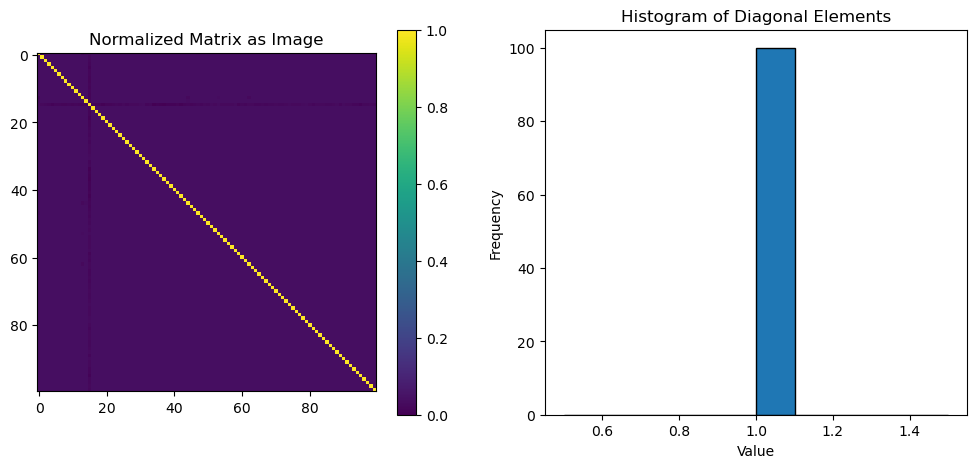

In [ ]:
print('determinant of L_norm_v2:', np.linalg.det(L_norm_v2))
L_norm_v2_matrix = L_norm_v2[:block,:block]
# print(L_norm_v2_matrix)

# Normalize the L_norm_v2_matrix to the range [0, 1]
normalized_L_norm_v2_matrix = (L_norm_v2_matrix - np.min(L_norm_v2_matrix)) / (np.max(L_norm_v2_matrix) - np.min(L_norm_v2_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the L_norm_v2_matrix
diagonal_elements = np.diag(normalized_L_norm_v2_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_L_norm_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

Just check if the number of clusters recommended is a bit too much?

In [ ]:
print(labels.shape)
Spectral_cluster_indices = labels

(1024,)


select the cluster indices

In [ ]:
# cluster_indices = getSpectralCluster(im_tiles1d, num_clusters)

Arranging clusters, means and medoids

In [ ]:
def calculate_medoid(cluster):
    """
    cluster: an mxN array of m vectors in a cluster
    """
    # Pairwise distances between points in the cluster
    distances = cdist(cluster, cluster, metric='euclidean')
    total_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(total_distances)

    # Medoid is the data point with the minimum total distance
    medoid = cluster[medoid_index]

    return medoid

def get_cluster_medoids(data, cluster_indices):
    """
    Inputs:
    data: an mxN array of m data vectors (points)
    cluster_indices: an mx1 array of m cluster indices

    Returns:
    clusters: a dictionary, indexed by cluster number and values are clustered arrays of data
    medoids: a dictionary, indexed by cluster number and values are the medoid data vector
    means: a dictionary, indexed by cluster number and values are means
    
    """
    unique_clusters = np.unique(cluster_indices)

    # Initialise a dictionary to store clusters
    clusters = {cluster: [] for cluster in unique_clusters}

    # Populate clusters dictionary with data points
    for i, cluster_index in enumerate(cluster_indices):
        clusters[cluster_index].append(data[i])

    # Calculate medoid for each cluster
    medoids = {cluster: calculate_medoid(np.array(points)) for cluster, points in clusters.items()}
    means = {cluster: np.mean(np.array(points), axis=0) for cluster, points in clusters.items()}

    return clusters, medoids, means

Centred Clusters

In [ ]:
clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, Spectral_cluster_indices)
print ('keys of clustered_data:' ,clustered_data.keys())
print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
print ('cluster_means[0] has shape' , cluster_means[0].shape)

def get_centered_clusters(clustered_data, cluster_means):
    centered_clusters = {cluster: (np.array(clustered_data[cluster])-cluster_means[cluster]) for cluster in clustered_data.keys()}
    return centered_clusters

centered_clusters = get_centered_clusters(clustered_data, cluster_means)

keys of clustered_data: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

In [ ]:
#check for mean zero--> checked
summa = 0
for i in range(num_clusters):
    summa += centered_clusters[i].sum()
print (summa)

NameError: name 'num_clusters' is not defined

In [ ]:
def pca_for_cluster(cluster):
    """ 
    Inputs:
    cluster- mxN centered array of vectors from a single cluster

    Returns:
    cluster_pca
    """
    assert isinstance(cluster, np.ndarray)

    pca = PCA()
    cluster_pca = pca.fit_transform(cluster)
    pca_vectors = pca.components_
    # print('pca vectors shape:', pca_vectors.shape)


    #padding to make the cumsum array have data_dim(8x8=64) length
    data_dim = cluster.shape[-1] 
    padding_size = max(0, data_dim - len(pca.explained_variance_ratio_))
    expl_var_ratio_cumul = np.cumsum(np.pad(pca.explained_variance_ratio_, (0, padding_size), 'constant', constant_values=0))

    return cluster_pca, expl_var_ratio_cumul, pca_vectors

#test pca function
cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(centered_clusters[0])
print(type(cluster_pca), cluster_pca.shape)
print(pca_vectors.shape)


<class 'numpy.ndarray'> (1, 1)
(1, 64)


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


In [ ]:
num_clusters = len(centered_clusters)
fig, axs = plt.subplots(nrows= num_clusters, ncols =1, figsize=(8,4* num_clusters))

#clusters_pcavectors and mean- a set basis(psi), one for each cluster
t_exp = 0.9
dynamic_psi = dict()
fixed_psi = dict()
dim_comp = 0.5
fixed_cut = int(dim_comp* np.square(tile_w))

for i, (cluster_key, points) in enumerate(centered_clusters.items()):
    cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

    # find the index that reaches 0.9 cumsum variability
    cutidx = np.argmax(expln_var_cum >= t_exp)
    dynamic_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
    fixed_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:fixed_cut]))

    # Add the dynamic_basis vectors describing the 0.9 variance
    dynamic_psi[cluster_key] = dynamic_basis

    # Add the fixed_basis vectors which are the 50% of the the basis vectors
    fixed_psi[cluster_key] = fixed_basis

    print('Cluster %d dynamic_basis vectors shape:'%(cluster_key), dynamic_basis.shape)
    print('Cluster compression when pruning %.2f variance is %.4f'%(t_exp, dynamic_basis.shape[0]/points.shape[0]))
    print('--------------------')
                      
    axs[i].plot(range(1, len(expln_var_cum) + 1), expln_var_cum, label='Cluster no.%d with %d vectors'%(cluster_key, points.shape[0]))
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumultiv Explained Var Ratio')
    axs[i].legend()

# plt.savefig('results/Patching_Image_%d.pdf'%(image_number))
plt.show()

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 0 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 1 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 0.5000
--------------------
Cluster 2 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 3 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 4 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 5 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 6 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 7 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 96 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 97 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 0.5000
--------------------
Cluster 98 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 99 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 100 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 101 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 102 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 103 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
---------

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 278 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 279 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 280 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 281 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 282 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 283 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 284 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 285 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
-----

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 388 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 389 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 390 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 391 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 392 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 393 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 394 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 395 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
-----

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

ValueError: Image size of 800x205600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x205600 with 514 Axes>

Approximate $\hat{x}$ for each data point inside the cluster

In [ ]:
# Approximate x_hat = Psi_k alpha; for each tile x_hat
def fit_to_basis(data_vectors, basis_vectors):
    """ 
    basis_vectors : an nxN array with a basis vector(N-dimensional) in each row 
    data_vectors : an mxN array with m examples of (N-dimensional) data.
    """ 
    projection_matrix = basis_vectors.T @ (np.linalg.pinv(basis_vectors @ basis_vectors.T) @ basis_vectors)
    approximations = data_vectors @ projection_matrix
    errors = np.linalg.norm(data_vectors - approximations , axis=1)
    # print(errors.shape)
    return approximations, errors

 cluster 0 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 1 has error after fitting: 
 dynamic basis selection: 81.8532 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 2 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 3 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 4 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 5 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 6 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 7 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 8 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 9 has error after fitting: 
 dynamic basis se

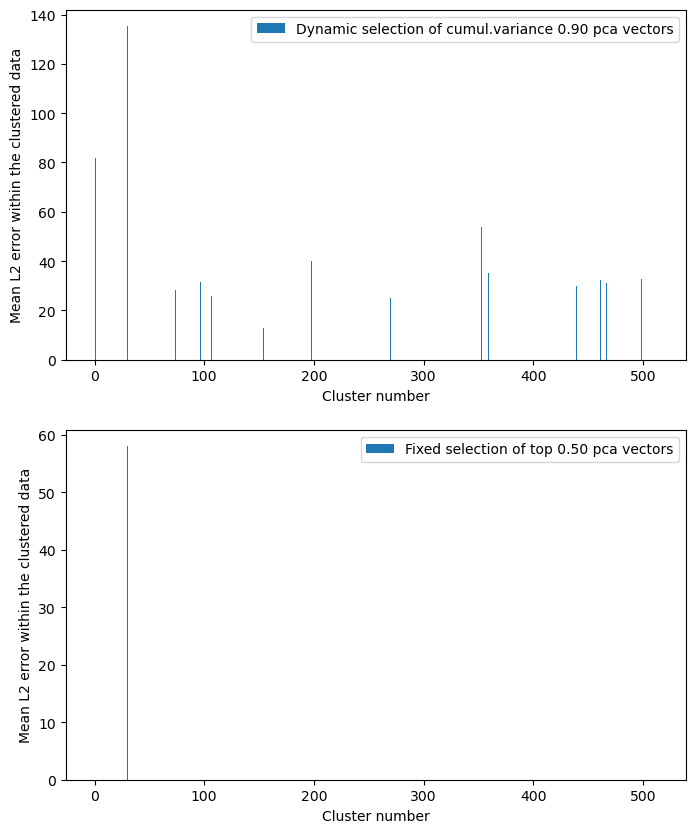

In [ ]:
dyn_errors = []
fix_errors = []
for i, (cluster_key, points) in enumerate(clustered_data.items()):
    dyn_approx, dyn_errs = fit_to_basis(clustered_data[cluster_key], dynamic_psi[cluster_key])
    fix_approx, fix_errs = fit_to_basis(clustered_data[cluster_key], fixed_psi[cluster_key])
    dyn_errors.append(np.mean(dyn_errs))
    fix_errors.append(np.mean(fix_errs))
    print(" cluster %d has error after fitting: \n dynamic basis selection: %.4f \n fixed top %.2f: %.4f \n ------ "%(i, np.mean(dyn_errs), dim_comp, np.mean(fix_errs)))

# print(np.array(dyn_errors).shape)

fig, axs = plt.subplots(nrows= 2, ncols =1, figsize=(8,10))
axs[0].bar(np.array(range(num_clusters)), dyn_errors, label='Dynamic selection of cumul.variance %.2f pca vectors'%(t_exp))
axs[0].set_xlabel('Cluster number')
axs[0].set_ylabel('Mean L2 error within the clustered data')
axs[0].legend()

axs[1].bar(range(num_clusters), fix_errors, label='Fixed selection of top %.2f pca vectors'%(dim_comp))
axs[1].set_xlabel('Cluster number')
axs[1].set_ylabel('Mean L2 error within the clustered data')
axs[1].legend()

### Approximate $\hat{x}$ for each $x$ datapoint in the original tiles1d so that I can recreate the image.

In [ ]:
print('1D data array shape:',im_tiles1d.shape)
print('cluster indices shape',cluster_indices.shape)


1D data array shape: (1024, 64)
cluster indices shape (1024,)


In [ ]:
def visualise_approx(im_tiles1d, cluster_indices):
    approx_data1d = np.zeros_like(im_tiles1d)
    error_data = np.zeros_like(im_tiles1d)
    for i in range(len(cluster_indices)):
        fix_approx, fix_errs = fit_to_basis(im_tiles1d[i][np.newaxis,:],fixed_psi[cluster_indices[i]])
        approx_data1d[i] = fix_approx
        error_data[i] = fix_errs

    num_tiles_x = int(np.sqrt(approx_data1d.shape[0]))
    num_tiles_y = int(np.sqrt(approx_data1d.shape[0]))
    tile_width = tile_w
    tile_height = tile_w
    approx_data2d = approx_data1d.reshape(num_tiles_x, num_tiles_x, tile_width, tile_height)
    approx_image = approx_data2d.transpose(0, 2, 1, 3).reshape(num_tiles_y*tile_height, num_tiles_x*tile_width)

    return approx_data2d, approx_image

approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
visualize_tiles(approx_data2d)

NameError: name 'cluster_indices' is not defined

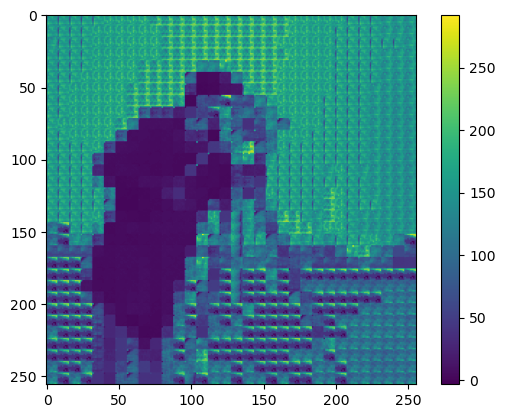

In [ ]:
plt.imshow(approx_image)
plt.colorbar()
plt.show()

In [ ]:
np.mean(np.square(approx_image - image))

2029.111925009437

### One function to rule them all :p

In [ ]:
def clusterdenoising(image, tile_w, num_clusters, t_ratio=0.5):
    """
    Inputs: An image to be denoised, tile width, number of PCA clusters
    Outputs: A cluster approximated image using to t_ratio of PCA vectors
    """
    im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
    im_tiles1d = im_tiles1d.astype(float)

    centroids, _ = kmeans(im_tiles1d, num_clusters)
    # print('data dimensions:', im_tiles1d.shape)
    # print('number of clusters:', num_clusters)
    # print('centroids shape:', centroids.shape)

    #vector quatization
    cluster_indices, _ = vq(im_tiles1d, centroids)
    # print('cluster_indices shape:', cluster_indices.shape)

    clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
    # print ('keys of clustered_data:' ,clustered_data.keys())
    # print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
    # print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
    # print ('cluster_means[0] has shape' , cluster_means[0].shape)

    centered_clusters = get_centered_clusters(clustered_data, cluster_means)

    t_exp = 0.9
    dynamic_psi = dict()
    fixed_psi = dict()
    dim_comp = t_ratio
    fixed_cut = int(dim_comp* np.square(tile_w))

    for i, (cluster_key, points) in enumerate(centered_clusters.items()):
        cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

        # find the index that reaches 0.9 cumsum variability
        cutidx = np.argmax(expln_var_cum >= t_exp)
        dynamic_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
        fixed_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:fixed_cut]))

        # Add the dynamic_basis vectors describing the 0.9 variance
        dynamic_psi[cluster_key] = dynamic_basis

        # Add the fixed_basis vectors which are the 50% of the the basis vectors
        fixed_psi[cluster_key] = fixed_basis


    approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
    return approx_data2d, approx_image

In [ ]:
_ , approx_image = clusterdenoising(image,tile_w=8,num_clusters=20,t_ratio=0.5)

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


In [ ]:
def compareNLM(image_number):
    image = cv2.imread(f"Dataset/Image{image_number}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mindim = np.min(image.shape)
    image = image[:mindim, :mindim]

    # Define Gaussian noise levels
    noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

    # Create a plot to display images
    plt.figure(figsize=(15, 8))

    #NLM args
    patch_kw = dict(patch_size=8,      # 8x8 patches
                    patch_distance=6,  # 13x13 search area
                    channel_axis=-1)

    mse_NLM = []
    mse_ours= []

    # Plot noisy images and denoised images
    for i, noise_level in enumerate(noise_levels):
        # Add Gaussian noise to the original image
        noisy_image = np.uint8(np.clip(image + np.random.normal(scale=noise_level, size=image.shape), 0, 255))
        
        # Denoise the noisy image (replace this with your denoising algorithm)
        _,ours_denoised = clusterdenoising(noisy_image,tile_w=8,num_clusters=20,t_ratio=0.5)

        #NLM Slow
        noisy_image_NLM = noisy_image[:,:, np.newaxis]
        sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
        NLM_denoised = (denoise_nl_means(noisy_image_NLM, h=0.7 * sigma_est, fast_mode=False,
                            **patch_kw) * 255).astype(np.uint8)

        mse_NLM.append(np.mean(np.square(NLM_denoised-image)))
        mse_ours.append(np.mean(np.square(ours_denoised-image)))

        # Plot the noisy image
        plt.subplot(3, 10, i + 1)
        plt.imshow(noisy_image)
        plt.title(f'Noisy (σ={noise_level})')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(3, 10, i + 11)
        plt.imshow(NLM_denoised)
        plt.title(f'AfterNLM (σ={noise_level})')
        plt.axis('off')
        
        # Plot the denoised image
        plt.subplot(3, 10, i + 21)
        plt.imshow(ours_denoised)
        plt.title(f'Ours (σ={noise_level})')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results/LASSO_Spectral_OursvsNLM_Image_%d_GaussianNoise.png'%(image_number))
    
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, mse_NLM, marker='o', label='NLM')
    plt.plot(noise_levels, mse_ours, marker='o', label='Ours')
    plt.title('MSE Losses for Denoising Methods')
    plt.xlabel('Noise Level')
    plt.ylabel('MSE Loss')
    plt.xticks(noise_levels)
    plt.grid(True)
    plt.legend()
    plt.savefig('results/LASSO_Spectral_OursvsNLM_Image_%d_GaussianNoise_MSE.png'%(image_number))
    

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


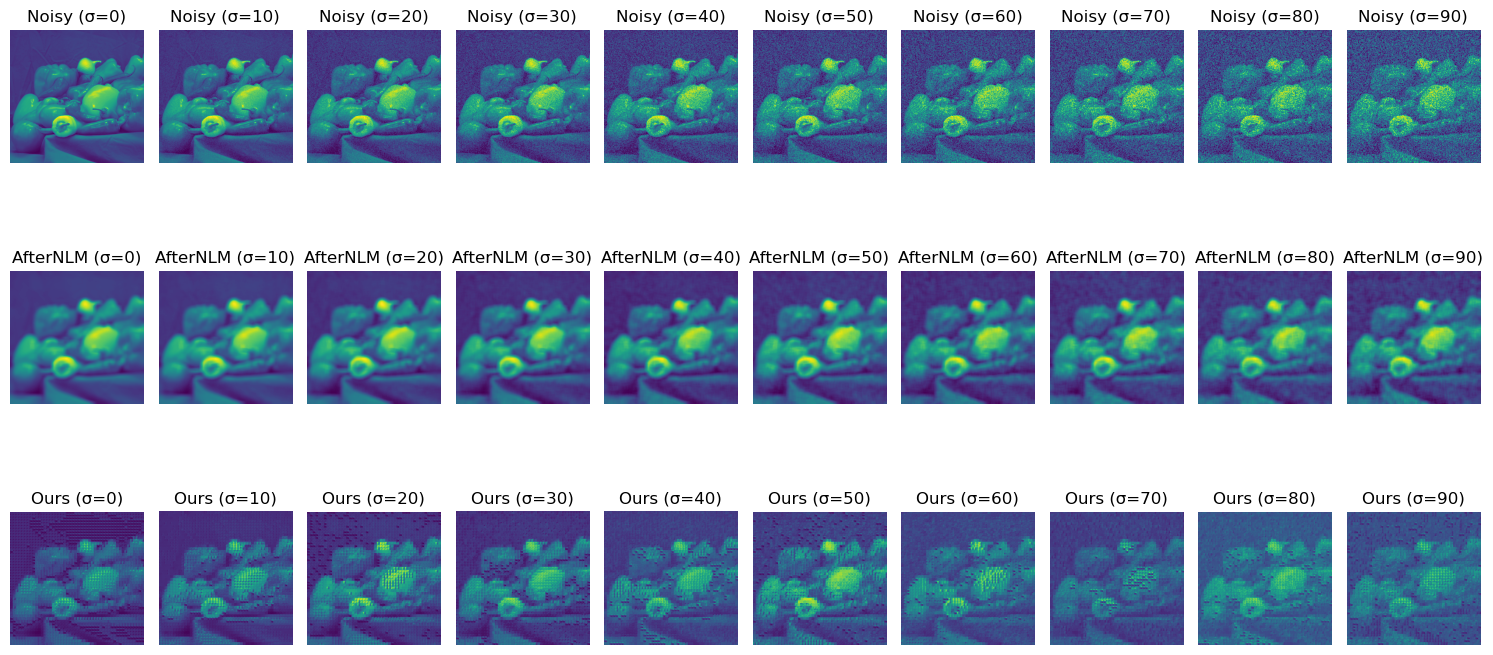

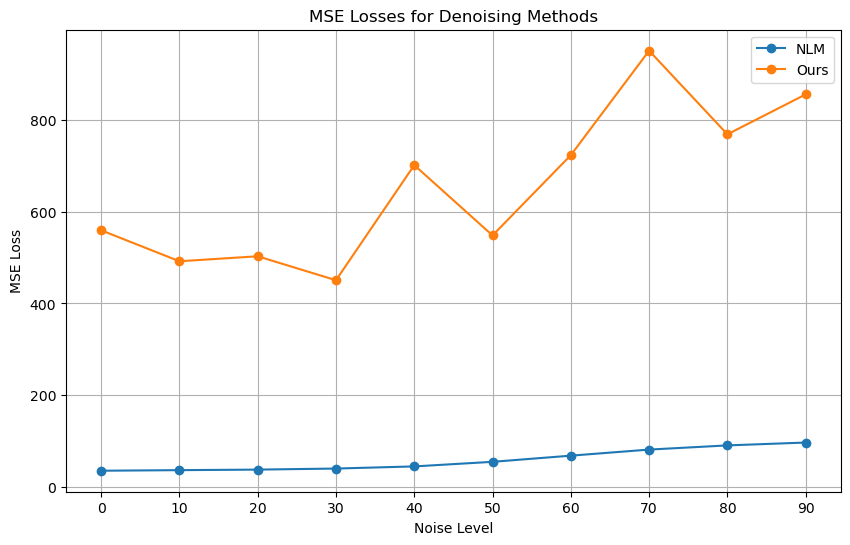

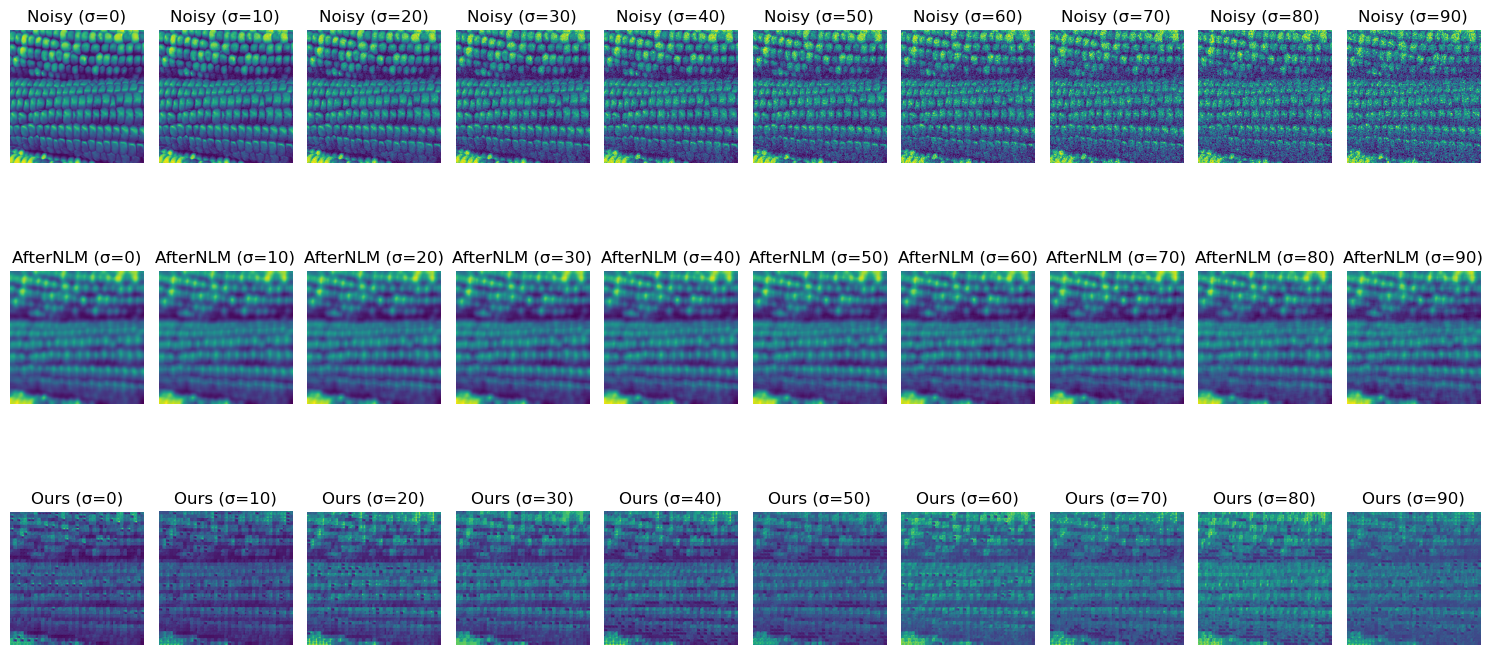

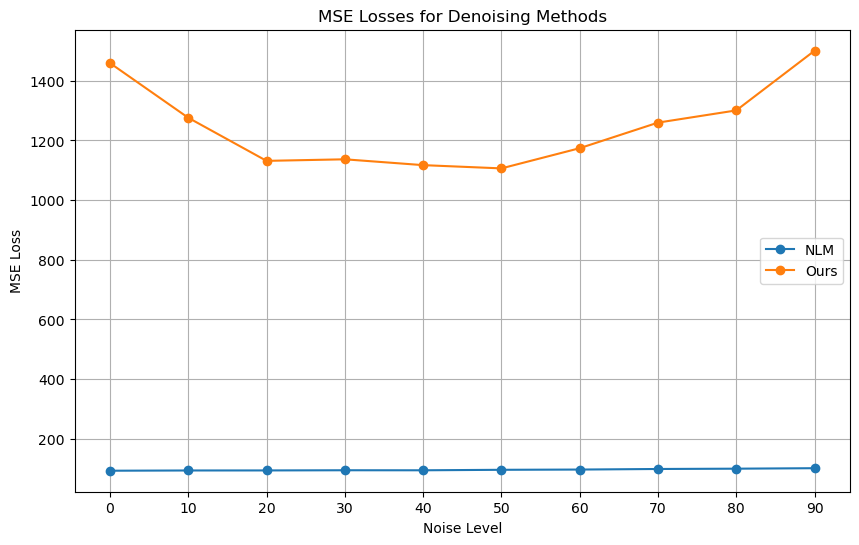

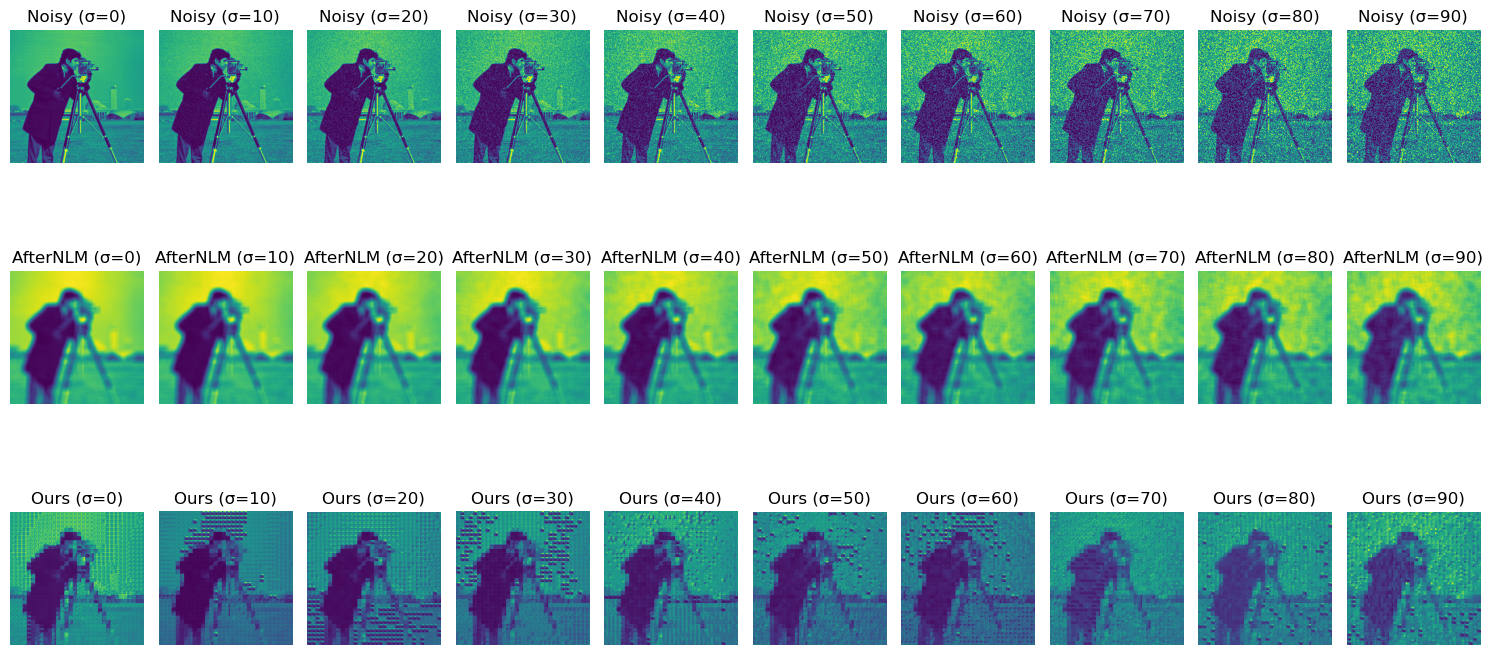

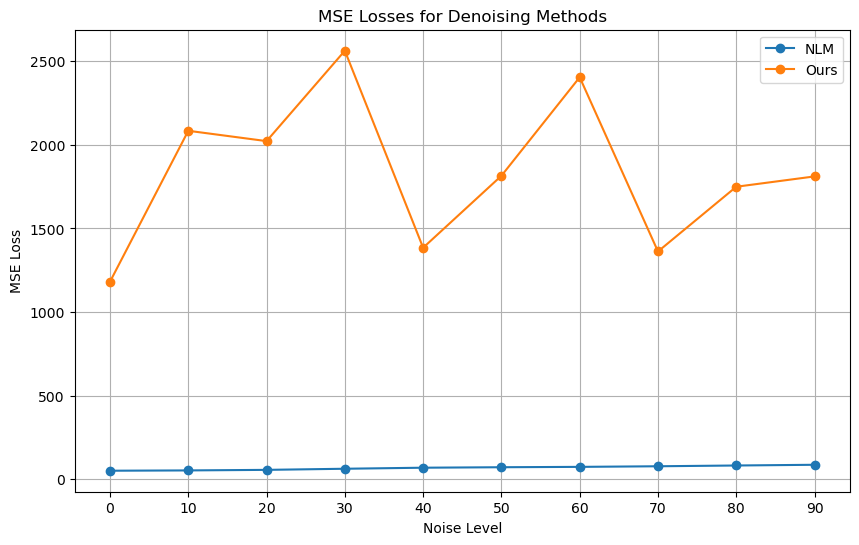

In [ ]:
for image_num in range(1,4):
    compareNLM(int(image_num))

In [ ]:
#Sanity check
#NLM args
patch_kw = dict(patch_size=8,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)
noisy_image = np.uint8(np.clip(image + np.random.normal(scale=50, size=image.shape), 0, 255))      
noisy_image_NLM = noisy_image[:,:, np.newaxis]
sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
NLM_denoised = denoise = (denoise_nl_means(noisy_image_NLM, h=1.5 * sigma_est, fast_mode=False,
                    **patch_kw) *255).astype(np.uint8)

print(np.mean(np.square(NLM_denoised-image)))

71.35722351074219
